<center><h1 style="text-align: center;"><u>TFM - Detección temprana del cáncer a partir de los resultados de análisis de sangre</u></h1>
<center><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="Drawing" style="align=left"/>

# INTRODUCCIÓN

En este notebook se lleva a cabo el contraste del modelo CancerA1DE para la detección prematura de cáncer frente a otros modelos de predicción.

El artículo sobre el que se basa esta investigación es "Early Cancer Detection from Multianalyte Blood Test Results" presente en : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6548890/

El contenido abarca un repaso de los datos, su análisis a todos los niveles y los diferentes enfoques para entrenar, validar y testear los distintos modelos.

Los datos se encontrarán en la siguiente ruta en local : C:\Users\danie\OneDrive\Documentos\Master\Lusku\TFM\Proposiciones\Deteccion Cancer\Datos

IMPORTANTE : Cada vez que tenga que rellenarse a mano el valor de una variable, se mostrará con : 

                    (I) Introducir valor de 'nombreDeLaVariable'

Para descargar las librerías usadas en este proyecto se puede hacer usar el comando "pip install -r requirements.txt" en el terminal

Los bloques de código que empiezan por # P , forman parte del proceso principal y son necesarios ejecutarse para seguir el flujo del proceso.

In [1]:
# P
# Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import normaltest

# Entrenar el modelo
from sklearn.model_selection import train_test_split

# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_classif

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, r2_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from joblib import dump, load


# Funciones

In [4]:
# Functions

# Conversion del dataFrame a tipo numeric
def convert_to_numeric(column):
    if column.dtype in ['object','category']:
        # Verificar si hay letras en todos los registros
        contains_letters = any(isinstance(val, str) and any(c.isalpha() for c in val) for val in column)
        if not contains_letters :
            return pd.to_numeric(column, errors='coerce')
    return column

def discretizar_df_arboles_1(df, max_depth=40, n_bins=18, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc' or columna.name == 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado.apply(convert_to_numeric)

# Discretizar dataFrame y mostrar correlación respecto a la variable objetivo
def discretizar_df_arboles(df, imprimir="SI", max_depth=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.select_dtypes(include=['number']).columns:
        if df[columna].dtype.kind in 'biufc' or columna.name != 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            # print(f"\t Columna : {columna} \n Puntos de Corte : \n {puntos_corte}")
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
   # Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
    correlaciones_discretas = df_discretizado.corrwith(df_discretizado['Tumor type'])

    # Ordenar las correlaciones de mayor a menor
    correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

    # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
    top_20_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(20)

    if imprimir == "SI":
        # Imprimir las top 20 correlaciones
        print(top_20_correlaciones_discretas)

    return df_discretizado


def escalado_dataFrame(df) :
    if df.empty:
        raise ValueError("El DataFrame está vacío, no se puede realizar el escalado.")

    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Normalizar df_imputacion_iterativa
    df_normalized = df.select_dtypes(include=['number']).copy()  # Crear una copia del DataFrame original
    
    if not df_normalized.empty:
        df_normalized[df_normalized.columns] = scaler.fit_transform(df_normalized)
    else :
        print("Esto está vacío")
    return df_normalized

def calcular_ganancia_informacion(df_features, target, imprimir = 'SI'):
    
    # Extraer las características de interés del DataFrame
    X_interest = df_features.values
    
    # Extraer la variable objetivo del DataFrame principal
    y = target.values
    
    # Calcular la Ganancia de Información utilizando Mutual Information
    information_gain = mutual_info_classif(X_interest, y, discrete_features=False, random_state=42, n_neighbors=7)
    
    # Crear un DataFrame para visualizar los resultados
    ig_results = pd.DataFrame({'Feature': df_features.columns, 'Information Gain': information_gain})
    
    # Ordenar los resultados por Ganancia de Información en orden descendente
    ig_results_sorted = ig_results.sort_values(by='Information Gain', ascending=False)

    if imprimir == "SI":
        print(ig_results_sorted)

# División del conjunto de datos en entrenamiento, validacion y test 


def split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=None):
    """
    Divide un conjunto de datos en entrenamiento, validación y test.

    Args:
        X: Matriz de características.
        y: Vector de etiquetas.
        train_size: Porcentaje de datos para entrenamiento (por defecto: 0.6).
        val_size: Porcentaje de datos para validación (por defecto: 0.2).
        test_size: Porcentaje de datos para test (por defecto: 0.2).
        random_state: Semilla para la aleatorización (por defecto: None).

    Returns:
        Tuple: (X_train, X_val, X_test, y_train, y_val, y_test).
    """
    assert train_size + val_size + test_size == 1.0, "La suma de train_size, val_size y test_size debe ser igual a 1.0"

    # Dividir los datos en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    # Calcular porcentaje respecto al tamaño original
    val_size_relative = val_size / (1.0 - test_size)

    # Dividir los datos de entrenamiento en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size_relative, random_state=random_state, shuffle=True)

    return X_train, X_val, X_test, y_train, y_val, y_test

def mostrar_cross_validation(model, X_train, y_train):
    cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )
    print("Cross validation : ")
    print(f"Métricas validación cruzada: {cv_scores}")
    print(f"Média métricas de validación cruzada: {cv_scores.mean()}")
    print("")

def mostrar_score(X_train, y_train, model):
    score = round(model.score(X_train, y_train), 3)*100
    print(f"Tanto por ciento de acierto : {score} %")
    print("")

def mostrar_estadisticas(y_val, y_pred) :
    mse = round(mean_squared_error(y_val, y_pred),3)
    accuracy = round(accuracy_score(y_val, y_pred),3)
    precision = round(precision_score(y_val, y_pred),3)
    recall = round(recall_score(y_val, y_pred),3)
    f1 = round(f1_score(y_val, y_pred),3)
    conf_matrix = confusion_matrix(y_val, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Error cuadrático medio en el conjunto de validación:", mse)
    print("Matriz de Confusión :\n", conf_matrix)
    print("")

def mostrar_curva_ROC(y_val, y_pred) :
    fpr, tpr, _ = roc_curve(y_val, y_pred)

    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Plotear la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"Metrics for {set_name} set:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Función para mostrar métricas y añadirlas a un DataFrame
def mostrar_estadisticas_guardar_tabla(y_val, y_pred, set_name, model_name, enfoque, print_roc = 'NO'):
    '''
    Ejemplo de uso :

    # Fase de entrenamiento
    results_df = mostrar_estadisticas_guardar_tabla(y_train, kmeans.predict(X_train_prep), "Training", results_df, model_name)

    # Fase de validación
    results_df = mostrar_estadisticas_guardar_tabla(y_val, kmeans.predict(X_val_prep), "Validation", results_df, model_name)

    # Fase de prueba
    results_df = mostrar_estadisticas_guardar_tabla(y_test, kmeans.predict(X_test_prep), "Test", results_df, model_name)

    # Importante: Al final de todos los modelos (fuera del método): Guardar los resultados en un archivo Excel
    results_df.to_excel('model_results.xlsx', index=False)

    '''
    global tabla_results_df
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    rand_index = adjusted_rand_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    if conf_matrix.shape == (2, 2):  # Asegúrate de que es una matriz de confusión 2x2
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        tn = fp = fn = tp = None  # Si no es una matriz 2x2, asigna valores None
    
    global_score = calcular_puntuacion_global(accuracy, precision, recall, f1, rand_index, r2, mse, tn, fp, fn, tp, roc_auc)
    
    # Imprimir todas las métricas
    print(f"Metrics for {set_name} set :")
    print(f" - Accuracy: {accuracy:.4f}")
    print(f" - Precision: {precision:.4f}")
    print(f" - Recall: {recall:.4f}")
    print(f" - F1-Score: {f1:.4f}")
    print(f" - Adjusted Rand Index: {rand_index:.4f}")
    print(f" - Mean Squared Error: {mse:.4f}")
    print(f" - R-squared: {r2:.4f}")
    print(f" - Área bajo la curva : {roc_auc:.3f}")
    print(f" - Confusion Matrix: \n{conf_matrix}")
    #if tn is not None and fp is not None and fn is not None and tp is not None:
    #   print(f"\tTN: {tn}\n\tFP: {fp}\n\tFN: {fn}\n\tTP: {tp}")
    print(f" - Global Score : {global_score}")
    print(f"")
    
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Approach': [enfoque],
        'Set': [set_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'Adjusted Rand Index': [rand_index],
        'Mean Squared Error': [mse],
        'R-squared': [r2],
        'AUC-ROC': [roc_auc],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'TP': [tp],
        'Global Score' : [global_score]
    })

    if (print_roc == 'SI') :
        plot_ROC(fpr, tpr, roc_auc)
    
    tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)
    
    return tabla_results_df

def plot_ROC(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

def calcular_puntuacion_global(accuracy, precision, recall, f1, rand_index, r2, mse, tn, fp, fn, tp, auc_roc):
    # Definir ponderaciones para cada métrica
    weights = {
        'accuracy': 0.12,
        'precision': 0.12,
        'recall': 0.12,
        'f1': 0.12,
        'rand_index': 0.1,
        'r2': 0.05,
        'mse': 0.05,
        'tpr': 0.1,
        'fpr': 0.1,
        'auc_roc': 0.12,
    }
    
     # Normalizar las métricas
    mse_norm = (1 - mse)  # Invertir MSE ya que menor es mejor
    r2_norm = (r2 + 1) / 2  # Normalizar R2 para que esté entre 0 y 1
    
    # TPR y FPR
    tpr = recall  # TPR es lo mismo que recall
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Asegurar no división por cero

    # Invertir FPR ya que menor es mejor
    fpr_inverted = 1 - fpr

    # Calcular la puntuación global
    global_score = (accuracy * weights['accuracy'] +
                    precision * weights['precision'] +
                    recall * weights['recall'] +
                    f1 * weights['f1'] +
                    rand_index * weights['rand_index'] +
                    r2_norm * weights['r2'] +
                    mse_norm * weights['mse'] +
                    tpr * weights['tpr'] +
                    fpr_inverted * weights['fpr'] +
                    auc_roc * weights['auc_roc'])
    
    return round(global_score * 100, 2)

# Funciones para aprendizaje no supervisado
def optimal_cluster_number(X_train, X_val, model, max_clusters=10, method='elbow', plot_grafica = 'NO'):
    """
    Encuentra el número óptimo de clusters para un modelo de clustering utilizando el método del codo (Elbow Method)
    u otros métodos.
    """
    if method == 'elbow':
        distortions = []
        for i in range(1, max_clusters + 1):
            model.n_clusters = i
            model.fit(X_train)
            distortions.append(model.inertia_)
        if plot_grafica == 'SI':
            # Plotting the elbow curve
            plt.plot(range(1, len(distortions) + 1), distortions, marker='o')
            plt.xlabel('Número de clusters')
            plt.ylabel('Distorsión')
            plt.title('Método del codo para encontrar el número óptimo de clusters')
            plt.show()

        # Finding the optimal number of clusters based on the elbow point
        optimal_k = np.argmin(np.gradient(distortions)) + 1
        if optimal_k == 1:  # Ensure that the optimal number of clusters is greater than 1
            optimal_k = 2
        return optimal_k

    elif method == 'silhouette':
        silhouette_scores = []
        for i in range(2, max_clusters + 1):
            model.n_clusters = i
            model.fit(X_train)
            labels = model.predict(X_val)
            silhouette_scores.append(silhouette_score(X_val, labels))
        
        if plot_grafica == 'SI':
            # Plotting the silhouette scores
            plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
            plt.xlabel('Número de clusters')
            plt.ylabel('Silhouette Score')
            plt.title('Silhouette Score para encontrar el número óptimo de clusters')
            plt.show()

        # Finding the optimal number of clusters based on silhouette score
        optimal_k = np.argmax(silhouette_scores) + 2
        return optimal_k

    else:
        raise ValueError("Método no válido. Métodos disponibles: 'elbow', 'silhouette', etc.")


# Función para motrar estadísticas para modelos de aprendizaje no supervisado   
def mostrar_estadisticas_guardar_tabla_NS(X, labels, set_name, model_name):
    '''
    Ejemplo de uso :

    # Fase de entrenamiento
    results_df = mostrar_estadisticas_guardar_tabla(X_train, kmeans.predict(X_train), "Training", model_name, results_df)

    # Fase de validación
    results_df = mostrar_estadisticas_guardar_tabla(X_val, kmeans.predict(X_val), "Validation", model_name, results_df)

    # Fase de prueba
    results_df = mostrar_estadisticas_guardar_tabla(X_test, kmeans.predict(X_test), "Test", model_name, results_df)

    # Importante: Al final de todos los modelos (fuera del método): Guardar los resultados en un archivo Excel
    results_df.to_excel('model_results.xlsx', index=False)
    '''
    global tabla_results_NS_df
    silhouette_avg = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    global_score = calcular_puntuacion_global_NS(silhouette_avg, db_score, ch_score)
    
    # Imprimir todas las métricas
    print(f"Metrics for {set_name} set ({model_name}):")
    print(f" - Silhouette Score: {silhouette_avg:.4f}")
    print(f" - Davies-Bouldin Index: {db_score:.4f}")
    print(f" - Calinski-Harabasz Index: {ch_score:.4f}")
    print(f" - Global Score: {global_score:.4f}")
    print(f"")
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Set': [set_name],
        'Silhouette Score': [silhouette_avg],
        'Davies-Bouldin Index': [db_score],
        'Calinski-Harabasz Index': [ch_score],
        'Global Score': [global_score]
    })
    
    tabla_results_NS_df = pd.concat([tabla_results_NS_df, new_row], ignore_index=True)
    
    return tabla_results_NS_df

def calcular_puntuacion_global_NS(silhouette_avg, db_score, ch_score):
    # Normalizando los valores para que estén en el rango de 0 a 100
    normalized_silhouette = (silhouette_avg + 1) * 50  # Ajustando el rango del Silhouette Score de -1 a 1 a 0 a 100
    normalized_davies_bouldin = (1 - db_score) * 50  # Ajustando el rango del Davies-Bouldin Index de 0 a 1 a 0 a 100

    # Calculando el puntaje global promediando los puntajes normalizados
    global_score = (normalized_silhouette + normalized_davies_bouldin + ch_score) / 3

    return global_score

def encontrar_numero_optimo_clusters(X_train, X_val, model, max_clusters=10, plot_grafica = 'NO'):
    wcss = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    global_scores = []

    for i in range(2, max_clusters+1):
        model.n_clusters = i
        model.fit(X_train)

        # Predecir las etiquetas para los datos de validación
        labels = model.predict(X_val)

        # Calcular las métricas
        silhouette = silhouette_score(X_val, labels)
        davies_bouldin = davies_bouldin_score(X_val, labels)
        calinski_harabasz = calinski_harabasz_score(X_val, labels)
        
        global_score = calcular_puntuacion_global_NS(silhouette, davies_bouldin, calinski_harabasz)
        
        wcss.append(model.inertia_)
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        calinski_harabasz_scores.append(calinski_harabasz)
        global_scores.append(global_score)

    if plot_grafica == 'SI':
        # Plot para el método del codo
        plt.figure(figsize=(12, 8))
        plt.plot(range(2, max_clusters+1), wcss, marker='o')
        plt.title('Método del Codo')
        plt.xlabel('Número de Clústeres')
        plt.ylabel('WCSS')
        plt.show()

        # Plot para las métricas de validación
        plt.figure(figsize=(12, 8))
        plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o', label='Silhouette Score')
        plt.plot(range(2, max_clusters+1), davies_bouldin_scores, marker='o', label='Davies-Bouldin Index')
        plt.plot(range(2, max_clusters+1), calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Index')
        plt.plot(range(2, max_clusters+1), global_scores, marker='o', label='Global Score')
        plt.title('Métricas de Validación para Diferentes Números de Clústeres')
        plt.xlabel('Número de Clústeres')
        plt.ylabel('Valor de la Métrica')
        plt.legend()
        plt.show()

    # Encontrar el número óptimo de clústeres basado en el puntaje global
    numero_optimo_clusters = range(2, max_clusters+1)[np.argmax(global_scores)]
    return numero_optimo_clusters

def invert_preprocessor(preprocessor, data_prep):
    # Obtén las columnas numéricas y categóricas del preprocesador
    numeric_cols = preprocessor.transformers_[0][2]
    cat_cols = preprocessor.transformers_[1][2]
    
    # Invertir la transformación para los datos numéricos
    scaler = preprocessor.named_transformers_['scale']
    numeric_data_transformed = data_prep[numeric_cols]
    original_numeric_data = scaler.inverse_transform(numeric_data_transformed)
    
    # Invertir la transformación para los datos categóricos
    onehot = preprocessor.named_transformers_['onehot']
    encoded_columns = onehot.get_feature_names_out(cat_cols)
    categorical_data_transformed = data_prep[encoded_columns]
    original_categorical_data = onehot.inverse_transform(categorical_data_transformed)
    
    # Combinar las columnas invertidas con las columnas restantes
    original_data = pd.DataFrame(original_numeric_data, columns=numeric_cols)
    for i, col in enumerate(cat_cols):
        original_data[col] = original_categorical_data[:, i]
    
    # Combinar las columnas originales si hay columnas que se pasaron sin transformar (remainder='passthrough')
    if preprocessor.remainder == 'passthrough':
        passthrough_cols = data_prep.columns.difference(numeric_cols + list(encoded_columns))
        passthrough_data = data_prep[passthrough_cols]
        original_data = pd.concat([original_data, passthrough_data.reset_index(drop=True)], axis=1)
    
    return original_data


# Procesamiento de datos

In [5]:
# Carga de la URL de donde se encuentran los datos 
# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan los datos
nombreArchivo = 'Tables_S1_to_S11' #nombre del archivo del dataset
url_datos = f'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Proposiciones/Deteccion Cancer/Datos/{nombreArchivo}.xlsx'

# Se procede a hacer una carga de los datos. 
df_original= pd.read_excel(url_datos, sheet_name='Table S6')

# Crear una copia del DataFrame original para realizar los cambios
df6 = df_original.copy()

# Recorrer las columnas del DataFrame para eliminar las cadenas de texto : ['*', '**']
for columna in df6.columns:
    if df6[columna].dtype == 'object':
        # Aplicar la sustitución para cada secuencia en secuencias_a_buscar
        for secuencia in ['*', '**']:
            df6[columna] = df6[columna].apply(lambda x: x.replace(secuencia, '') if isinstance(x, str) and secuencia in x else x)

df_prep = df6.apply(convert_to_numeric)

# Relleno de nulos de la variable "AJCC Stage"
df_prep["AJCC Stage"] = df_prep["AJCC Stage"].fillna("0")

# Calcular la media solo para las columnas numéricas
numeric_columns = df_prep.select_dtypes(include=['number'])
mean_values = numeric_columns.mean()

# Rellenar los valores nulos con la media correspondiente
df = df_prep.copy()  # Copiar el DataFrame preprocesado para evitar modificarlo
for col in mean_values.index:
    df[col].fillna(mean_values[col], inplace=True)


# Binarización "Tumor Type" 0 -> NO CANCER; 1 -> SI CANCER + 'CancerSEEK Test Result'
df['Tumor type'] = df['Tumor type'].apply(lambda x: 0 if str(x).strip().lower() == "normal" else 1).astype(int)
#df['CancerSEEK Test Result'] = df['CancerSEEK Test Result'].apply(lambda x: 0 if str(x).strip().lower() == "negative" else 1).astype(int)

# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['Tumor type','CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']

## --- CHECKPOINT ----- Datos limpios

# Columna objetivo
Y_column = df['Tumor type'].copy()
# Reducción del dataFrame
df_reduced = df[columnas_a_conservar].copy()
#Copia del dataFrame entero
df_full = df.copy()

''' INICIO - Verificacion del information gain'''
# Information Gain inicial
df_discretizado = discretizar_df_arboles_1(df_reduced.drop(columns=['Tumor type']))
df_reduced_discretizado_escalated = escalado_dataFrame(df_discretizado)
calcular_ganancia_informacion(df_reduced_discretizado_escalated, Y_column, imprimir = "NO")

# Information Gain usando arboles de decision (acorde a : "..the cancer antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the purity and accuracy measurements..")
df_discretizado_full = discretizar_df_arboles(df_full, imprimir ="NO") # Columnas de este segundo enfoque guardadas en columnas_segundo_enfoque
df_discretizado_reduced = discretizar_df_arboles(df_reduced,imprimir ="NO")

''' FIN - Verificacion del information gain'''

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE SUPERVISADO
tabla_results_df = pd.DataFrame(columns=['Model', 'Approach', 'Set', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Adjusted Rand Index', 'Mean Squared Error', 'R-squared','AUC-ROC', 'TN', 'FP', 'FN', 'TP', 'Global Score'])

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE NO SUPERVISADO
tabla_results_NS_df = pd.DataFrame(columns=['Model', 'Set', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Global Score'])

## --- CHECKPOINT ----- Datos discretizados + Information gain
# TODO Una vez hechos los modelos, habrá que estudiar cómo influye el usar esta serie de variables en la predicción
columnas_segundo_enfoque = ['Tumor type','OPN (pg/ml)','IL-6 (pg/ml)','IL-8 (pg/ml)','HGF (pg/ml)','Prolactin (pg/ml)','Omega score','GDF15 (ng/ml)','CYFRA 21-1 (pg/ml)','Myeloperoxidase (ng/ml)','sEGFR (pg/ml)']
df_reduced_segundo_enfoque = df[columnas_segundo_enfoque].copy()


''' Valores para X
1. df : entero, limpio, sin normalizar ni discretizar
2. df_reduced : reducido, limpio, sin normalizar ni discretizar
3. df_reduced_discretizado_escalated --> Acorde a la Tabla 1
4. df_discretizado_full.drop(columns=['Tumor type']) --> Acorde a la Figura S3 (usando todas las variables) discretizado con arbol de decisión
5. df_discretizado_reduced.drop(columns=['Tumor type']) --> Acorde a la Figura S3; discretizado con arbol de decisión
'''
''' Enfoque 1 '''
y = df_reduced['Tumor type']
X = df_reduced.drop(columns='Tumor type')

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

# TODO DUDA - Añadir un proceso de discretización? Puede mejorar el resultado. Ver cómo influye usar la función 'discretizar_df_arboles' ó la función sklearn.preprocessing.KBinsDiscretizer
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep  = preprocessor.transform(X_test)
df_red_prep = preprocessor.transform(df_reduced)  

X_prep = np.vstack((X_train_prep, X_val_prep, X_test_prep))

''' Enfoque 2 '''
y = df_reduced_segundo_enfoque['Tumor type']
X = df_reduced_segundo_enfoque.drop(columns='Tumor type')

X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

numeric_cols_2 = X_train_2.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols_2 = X_train_2.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols_2),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

# TODO DUDA - Añadir un proceso de discretización? Puede mejorar el resultado. Ver cómo influye usar la función 'discretizar_df_arboles' ó la función sklearn.preprocessing.KBinsDiscretizer
X_train_prep_2 = preprocessor.fit_transform(X_train_2)
X_val_prep_2 = preprocessor.transform(X_val_2)
X_test_prep_2  = preprocessor.transform(X_test_2)

X_prep_2 = np.vstack((X_train_prep_2, X_val_prep_2, X_test_prep_2))


# Aprendizaje supervisado

## Regresión lineal

In [15]:
# Crear una instancia del modelo de regresión lineal
model_LR = LinearRegression()
model_name = "Regresion Lineal"

# Definir un umbral
umbral = 0.5

# Cross validation
mostrar_cross_validation(model_LR, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LR.fit(X_train_prep, y_train)

#print("Fase de ENTRENAMIENTO estadísticas :")
#mostrar_score(X_train_prep, y_train, model_LR)
mostrar_estadisticas_guardar_tabla(y_train, np.where(model_LR.predict(X_train_prep) > umbral, 1, 0), "Training", model_name, enfoque="1", print_roc = "NO")

# Predecir en el conjunto de validación
y_pred = model_LR.predict(X_val_prep)

# Binarizar las predicciones
y_pred_bin = np.where(y_pred > umbral, 1, 0)

y_test_pred = model_LR.predict(X_test_prep)
y_test_pred_bin = np.where(y_test_pred > umbral, 1, 0)

mostrar_estadisticas_guardar_tabla(y_val, y_pred_bin, "Validation",  model_name, enfoque = "1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_bin, "Test", model_name, enfoque = "1", print_roc = "NO")

''' Enfoque 2 ''' 
model_LR_2 = LinearRegression()

# Cross validation
mostrar_cross_validation(model_LR_2, X_train_prep_2, y_train_2)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LR_2.fit(X_train_prep_2, y_train_2)

#print("Fase de ENTRENAMIENTO estadísticas :")
#mostrar_score(X_train_prep, y_train, model_LR)
mostrar_estadisticas_guardar_tabla(y_train_2, np.where(model_LR_2.predict(X_train_prep_2) > umbral, 1, 0), "Training", model_name, enfoque="2", print_roc = "NO")

# Predecir en el conjunto de validación
y_val_pred_2 = model_LR_2.predict(X_val_prep_2)

# Binarizar las predicciones
y_val_pred_bin_2 = np.where(y_val_pred_2 > umbral, 1, 0)

y_test_pred_2 = model_LR_2.predict(X_test_prep_2)
y_test_pred_bin_2 = np.where(y_test_pred_2 > umbral, 1, 0)

mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_bin_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_bin_2, "Test", model_name, enfoque="2", print_roc = "NO")


dump(model_LR, 'Modelos supervisados entrenados/regresionLineal_e1_1.joblib')
dump(model_LR_2, 'Modelos supervisados entrenados/regresionLineal_e2_1.joblib')


Cross validation : 
Métricas validación cruzada: [-0.42597539 -0.40579938 -0.39606393 -0.42963374 -0.4116208 ]
Média métricas de validación cruzada: -0.4138186485421042

Metrics for Training set :
 - Accuracy: 0.8026
 - Precision: 0.8303
 - Recall: 0.8026
 - F1-Score: 0.8018
 - Adjusted Rand Index: 0.3655
 - Mean Squared Error: 0.1974
 - R-squared: 0.2014
 - Área bajo la curva : 0.815
 - Confusion Matrix: 
[[452  35]
 [180 422]]
 - Global Score : 76.6

Metrics for Validation set :
 - Accuracy: 0.7747
 - Precision: 0.8163
 - Recall: 0.7747
 - F1-Score: 0.7718
 - Adjusted Rand Index: 0.2997
 - Mean Squared Error: 0.2253
 - R-squared: 0.0910
 - Área bajo la curva : 0.789
 - Confusion Matrix: 
[[155  10]
 [ 72 127]]
 - Global Score : 73.86

Metrics for Test set :
 - Accuracy: 0.7610
 - Precision: 0.7970
 - Recall: 0.7610
 - F1-Score: 0.7597
 - Adjusted Rand Index: 0.2702
 - Mean Squared Error: 0.2390
 - R-squared: 0.0298
 - Área bajo la curva : 0.777
 - Confusion Matrix: 
[[145  15]
 [ 72 

['Modelos supervisados entrenados/regresionLineal_e2_1.joblib']

## Regresión logística

In [16]:
from sklearn.linear_model import LogisticRegression
model_name = "Regresión Logística"
print(model_name)
# Crear una instancia del modelo de regresión logística
model_LogR = LogisticRegression()

# Cross validation
mostrar_cross_validation(model_LogR, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LogR.fit(X_train_prep, y_train)

y_train_pred = model_LogR.predict(X_train_prep)
y_val_pred = model_LogR.predict(X_val_prep)
y_test_pred = model_LogR.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 ''' 
model_LogR_2 = LogisticRegression()

model_LogR_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = model_LogR_2.predict(X_train_prep_2)
y_val_pred_2 = model_LogR_2.predict(X_val_prep_2)
y_test_pred_2 = model_LogR_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(model_LogR, 'Modelos supervisados entrenados/regresionLogistica_e1_1.joblib')
dump(model_LogR_2, 'Modelos supervisados entrenados/regresionLogistica_e2_1.joblib')

Regresión Logística
Cross validation : 
Métricas validación cruzada: [-0.4336743  -0.4175068  -0.33864273 -0.4175068  -0.38996632]
Média métricas de validación cruzada: -0.39945938904769146

Metrics for Training set :
 - Accuracy: 0.8430
 - Precision: 0.8488
 - Recall: 0.8430
 - F1-Score: 0.8434
 - Adjusted Rand Index: 0.4700
 - Mean Squared Error: 0.1570
 - R-squared: 0.3648
 - Área bajo la curva : 0.847
 - Confusion Matrix: 
[[431  56]
 [115 487]]
 - Global Score : 80.31

Metrics for Validation set :
 - Accuracy: 0.8324
 - Precision: 0.8448
 - Recall: 0.8324
 - F1-Score: 0.8325
 - Adjusted Rand Index: 0.4405
 - Mean Squared Error: 0.1676
 - R-squared: 0.3238
 - Área bajo la curva : 0.839
 - Confusion Matrix: 
[[150  15]
 [ 46 153]]
 - Global Score : 79.46

Metrics for Test set :
 - Accuracy: 0.7995
 - Precision: 0.8137
 - Recall: 0.7995
 - F1-Score: 0.8000
 - Adjusted Rand Index: 0.3569
 - Mean Squared Error: 0.2005
 - R-squared: 0.1859
 - Área bajo la curva : 0.808
 - Confusion Matr

['Modelos supervisados entrenados/regresionLogistica_e2_1.joblib']

## Arbol de decisión

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model_name = "Árbol de Decisión"
print(model_name)
model_DT_leaf = DecisionTreeClassifier(random_state=42)

# Definir los parámetros a ajustar
params = {'max_leaf_nodes': range(2, 50)}  # Probando diferentes valores para max_leaf_nodes

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None,5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': range(2, 50)
}

# Realizar la búsqueda en rejilla con validación cruzada
grid_search = grid_search_2 = GridSearchCV(model_DT_leaf, param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train_prep, y_train)

# Mostrar los resultados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

model_DT = grid_search.best_estimator_

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_DT.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_DT, X_train_prep, y_train)

y_train_pred = model_DT.predict(X_train_prep)
y_val_pred = model_DT.predict(X_val_prep)
y_test_pred = model_DT.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(model_DT, 'Modelos supervisados entrenados/arbolesDecision_e1_1.joblib')


''' Enfoque 2 ''' 
grid_search_2.fit(X_train_prep_2, y_train_2)

model_DT_2 = grid_search_2.best_estimator_

model_DT_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = model_DT_2.predict(X_train_prep_2)
y_val_pred_2 = model_DT_2.predict(X_val_prep_2)
y_test_pred_2 = model_DT_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(model_DT_2, 'Modelos supervisados entrenados/arbolesDecision_e2_1.joblib')

Árbol de Decisión


KeyboardInterrupt: 

## Random forest

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
model_name = "Random Forest"
print(model_name)
RF = RandomForestClassifier()

rf_params = {
    "n_estimators": [100, 200, 300, 400, 500],  
    "max_depth": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  
    "max_features": [None, "sqrt", "log2"], 
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 4], 
    "bootstrap": [True, False]  
}
'''
rf_params = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
'''
random_search = random_search_2 = RandomizedSearchCV(estimator=RF,
                                   param_distributions=rf_params,
                                   n_iter=100,  
                                   cv=5,  
                                   verbose=0, 
                                   random_state=42,
                                   n_jobs=-1) 

# random_search.fit(X_train_prep, y_train)

# print("Mejores parámetros encontrados:", random_search.best_params_)
# {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

# model_RF = random_search.best_estimator_
params = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
model_RF = RandomForestClassifier(**params)
model_RF.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_RF, X_train_prep, y_train)

y_train_pred = model_RF.predict(X_train_prep)
y_val_pred = model_RF.predict(X_val_prep)
y_test_pred = model_RF.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(model_RF, 'Modelos supervisados entrenados/randomForest_e1_1.joblib')

''' Enfoque 2 ''' 
# random_search_2.fit(X_train_prep_2, y_train_2)

# print("Mejores parámetros encontrados:", random_search.best_params_)
# {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

# model_RF_2 = random_search_2.best_estimator_
params_2 = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

model_RF_2 = RandomForestClassifier(**params_2)
model_RF_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = model_RF_2.predict(X_train_prep_2)
y_val_pred_2 = model_RF_2.predict(X_val_prep_2)
y_test_pred_2 = model_RF_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(model_RF_2, 'Modelos supervisados entrenados/randomForest_e2_1.joblib')


Random Forest
Cross validation : 
Métricas validación cruzada: [-0.35192785 -0.31037119 -0.27925195 -0.28734789 -0.33942212]
Média métricas de validación cruzada: -0.3136641980878063

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[487   0]
 [  0 602]]
 - Global Score : 100.0

Metrics for Validation set :
 - Accuracy: 0.9121
 - Precision: 0.9129
 - Recall: 0.9121
 - F1-Score: 0.9118
 - Adjusted Rand Index: 0.6783
 - Mean Squared Error: 0.0879
 - R-squared: 0.6453
 - Área bajo la curva : 0.909
 - Confusion Matrix: 
[[144  21]
 [ 11 188]]
 - Global Score : 88.0

Metrics for Test set :
 - Accuracy: 0.9093
 - Precision: 0.9098
 - Recall: 0.9093
 - F1-Score: 0.9090
 - Adjusted Rand Index: 0.6692
 - Mean Squared Error: 0.0907
 - R-squared: 0.6320
 - Área bajo la curva : 0.905
 - Confusion Matrix: 
[[1

['Modelos supervisados entrenados/randomForest_e2_1.joblib']

## KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
model_name = "KNN"
print(model_name)
# Parámetros de búsqueda para KNN
'''
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
'''

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50]
}
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 3,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 30,
    'metric': 'hamming',
    'n_neighbors': 7,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 30,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}

#grid_search_knn = grid_search_knn_2 = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn = KNeighborsClassifier(**best_params_knn)
grid_search_knn_2 = KNeighborsClassifier(**best_params_knn_2)

grid_search_knn.fit(X_train_prep, y_train)

#print("Best parameters for KNN: ", grid_search_knn.best_params_)

y_train_pred = grid_search_knn.predict(X_train_prep)
y_val_pred = grid_search_knn.predict(X_val_prep)
y_test_pred = grid_search_knn.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_knn, 'Modelos supervisados entrenados/knn_e1_1.joblib')

''' Enfoque 2 '''
grid_search_knn_2.fit(X_train_prep_2, y_train_2)

#print("Best parameters for KNN: ", grid_search_knn_2.best_params_) 

grid_search_knn_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_knn_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_knn_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_knn_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")


dump(grid_search_knn_2, 'Modelos supervisados entrenados/knn_e2_1.joblib')

KNN
Metrics for Training set :
 - Accuracy: 0.9633
 - Precision: 0.9634
 - Recall: 0.9633
 - F1-Score: 0.9633
 - Adjusted Rand Index: 0.8583
 - Mean Squared Error: 0.0367
 - R-squared: 0.8514
 - Área bajo la curva : 0.963
 - Confusion Matrix: 
[[470  17]
 [ 23 579]]
 - Global Score : 95.11

Metrics for Validation set :
 - Accuracy: 0.9368
 - Precision: 0.9388
 - Recall: 0.9368
 - F1-Score: 0.9369
 - Adjusted Rand Index: 0.7626
 - Mean Squared Error: 0.0632
 - R-squared: 0.7450
 - Área bajo la curva : 0.939
 - Confusion Matrix: 
[[159   6]
 [ 17 182]]
 - Global Score : 91.94

Metrics for Test set :
 - Accuracy: 0.9286
 - Precision: 0.9286
 - Recall: 0.9286
 - F1-Score: 0.9286
 - Adjusted Rand Index: 0.7339
 - Mean Squared Error: 0.0714
 - R-squared: 0.7100
 - Área bajo la curva : 0.928
 - Confusion Matrix: 
[[147  13]
 [ 13 191]]
 - Global Score : 90.43

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.00

C:\Users\danie\AppData\Local\Temp\ipykernel_25016\2151088884.py:271: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)


['Modelos supervisados entrenados/knn_e2_1.joblib']

## SVM

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model_name = "SVM"
print(model_name)
# Define la cuadrícula de parámetros para buscar
'''param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}'''
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],              # Grados para el kernel polinómico
    'coef0': [0.0, 0.1, 0.5, 1.0],     # Término independiente en los kernels polinómico y sigmoidal
    'shrinking': [True, False],       # Si se debe usar la heurística de encogimiento
    'decision_function_shape': ['ovo', 'ovr']  # Forma de la función de decisión para clasificación multiclase
}

# Crea un objeto GridSearchCV
# grid_search_svm = grid_search_svm_2 = GridSearchCV(SVC(), param_grid, refit=True)

best_param = {'C': 100, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}
# Ajusta el objeto GridSearchCV a los datos

grid_search_svm = SVC(**best_param)

grid_search_svm.fit(X_train_prep, y_train)

# Imprime los mejores parámetros
# print("Mejores parámetros: ", grid_search_svm.best_params_)

y_train_pred = grid_search_svm.predict(X_train_prep)
y_val_pred = grid_search_svm.predict(X_val_prep)
y_test_pred = grid_search_svm.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_svm, 'Modelos supervisados entrenados/svm_e1_1.joblib')


''' Enfoque 2 ''' 
best_param_2 =  {'C': 100, 'coef0': 1.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'shrinking': True}
grid_search_svm_2 = SVC(**best_param_2)
grid_search_svm_2.fit(X_train_prep_2, y_train_2)

# print("Best parameters for KNN: ", grid_search_svm_2.best_params_) 

grid_search_svm_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_svm_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_svm_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_svm_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_svm_2, 'Modelos supervisados entrenados/svm_e2_1.joblib')

SVM
Metrics for Training set :
 - Accuracy: 0.8549
 - Precision: 0.8590
 - Recall: 0.8549
 - F1-Score: 0.8553
 - Adjusted Rand Index: 0.5034
 - Mean Squared Error: 0.1451
 - R-squared: 0.4131
 - Área bajo la curva : 0.858
 - Confusion Matrix: 
[[432  55]
 [103 499]]
 - Global Score : 81.65

Metrics for Validation set :
 - Accuracy: 0.8489
 - Precision: 0.8524
 - Recall: 0.8489
 - F1-Score: 0.8492
 - Adjusted Rand Index: 0.4855
 - Mean Squared Error: 0.1511
 - R-squared: 0.3903
 - Área bajo la curva : 0.851
 - Confusion Matrix: 
[[145  20]
 [ 35 164]]
 - Global Score : 80.86

Metrics for Test set :
 - Accuracy: 0.8049
 - Precision: 0.8117
 - Recall: 0.8049
 - F1-Score: 0.8057
 - Adjusted Rand Index: 0.3703
 - Mean Squared Error: 0.1951
 - R-squared: 0.2082
 - Área bajo la curva : 0.809
 - Confusion Matrix: 
[[135  25]
 [ 46 158]]
 - Global Score : 75.67

Metrics for Training set :
 - Accuracy: 0.8843
 - Precision: 0.8890
 - Recall: 0.8843
 - F1-Score: 0.8846
 - Adjusted Rand Index: 0.59

['Modelos supervisados entrenados/svm_e2_1.joblib']

## Naive Bayes

### Gaussiano

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

model_NB = GaussianNB()
model_name = "Naive Bayes - Gaussian"
print(model_name)

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search_nb = grid_search_nb_2 = GridSearchCV(model_NB, param_grid, cv=5, refit=True)

grid_search_nb.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_NB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
grid_search_nb.fit(X_train_prep, y_train)

y_train_pred = grid_search_nb.predict(X_train_prep)
y_val_pred = grid_search_nb.predict(X_val_prep)
y_test_pred = grid_search_nb.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_nb, 'Modelos supervisados entrenados/nb_gauss_e1_1.joblib')


''' Enfoque 2 ''' 

grid_search_nb_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_nb_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_nb_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_nb_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_nb_2, 'Modelos supervisados entrenados/nb_gauss_e2_1.joblib')


Naive Bayes - Gaussian
Cross validation : 
Métricas validación cruzada: [-0.51580524 -0.48367856 -0.44412578 -0.49770114 -0.46539216]
Média métricas de validación cruzada: -0.4813405758378038

Metrics for Training set :
 - Accuracy: 0.7668
 - Precision: 0.8266
 - Recall: 0.7668
 - F1-Score: 0.7620
 - Adjusted Rand Index: 0.2833
 - Mean Squared Error: 0.2332
 - R-squared: 0.0565
 - Área bajo la curva : 0.786
 - Confusion Matrix: 
[[471  16]
 [238 364]]
 - Global Score : 73.54

Metrics for Validation set :
 - Accuracy: 0.7830
 - Precision: 0.8457
 - Recall: 0.7830
 - F1-Score: 0.7779
 - Adjusted Rand Index: 0.3180
 - Mean Squared Error: 0.2170
 - R-squared: 0.1242
 - Área bajo la curva : 0.800
 - Confusion Matrix: 
[[163   2]
 [ 77 122]]
 - Global Score : 75.49

Metrics for Test set :
 - Accuracy: 0.7088
 - Precision: 0.7923
 - Recall: 0.7088
 - F1-Score: 0.6989
 - Adjusted Rand Index: 0.1707
 - Mean Squared Error: 0.2912
 - R-squared: -0.1821
 - Área bajo la curva : 0.735
 - Confusion M

['Modelos supervisados entrenados/nb_gauss_e2_1.joblib']

### Bernouilli

In [22]:
from sklearn.naive_bayes import BernoulliNB

model_NBB = BernoulliNB()
model_name = "Naive Bayes - Bernoulli"
print(model_name)

param_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
    'binarize': [None, 0.0, 0.1, 0.5, 1.0]
}
# Crea un objeto GridSearchCV
grid_search_nbb = grid_search_nbb_2 = GridSearchCV(model_NBB, param_grid, cv=5, refit=True)

# Ajusta el objeto GridSearchCV a los datos de entrenamiento preprocesados
grid_search_nbb.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_NBB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
grid_search_nbb.fit(X_train_prep, y_train)

y_train_pred = grid_search_nbb.predict(X_train_prep)
y_pred = grid_search_nbb.predict(X_val_prep)
y_test_pred = grid_search_nbb.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_nbb, 'Modelos supervisados entrenados/nb_bernouilli_e1_1.joblib')

''' Enfoque 2 ''' 

grid_search_nbb_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_nbb_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_nbb_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_nbb_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_nbb_2, 'Modelos supervisados entrenados/nb_bernouilli_e2_1.joblib')

Naive Bayes - Bernoulli


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\

Cross validation : 
Métricas validación cruzada: [-0.46923713 -0.47409982 -0.4175068  -0.51580524 -0.46539216]
Média métricas de validación cruzada: -0.4684082305729117



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep 

Metrics for Training set :
 - Accuracy: 0.8246
 - Precision: 0.8304
 - Recall: 0.8246
 - F1-Score: 0.8251
 - Adjusted Rand Index: 0.4210
 - Mean Squared Error: 0.1754
 - R-squared: 0.2905
 - Área bajo la curva : 0.828
 - Confusion Matrix: 
[[421  66]
 [125 477]]
 - Global Score : 78.05

Metrics for Validation set :
 - Accuracy: 0.9368
 - Precision: 0.9388
 - Recall: 0.9368
 - F1-Score: 0.9369
 - Adjusted Rand Index: 0.7626
 - Mean Squared Error: 0.0632
 - R-squared: 0.7450
 - Área bajo la curva : 0.939
 - Confusion Matrix: 
[[159   6]
 [ 17 182]]
 - Global Score : 91.94

Metrics for Test set :
 - Accuracy: 0.8049
 - Precision: 0.8178
 - Recall: 0.8049
 - F1-Score: 0.8055
 - Adjusted Rand Index: 0.3702
 - Mean Squared Error: 0.1951
 - R-squared: 0.2082
 - Área bajo la curva : 0.812
 - Confusion Matrix: 
[[140  20]
 [ 51 153]]
 - Global Score : 76.1



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_lo

Metrics for Training set :
 - Accuracy: 0.8145
 - Precision: 0.8222
 - Recall: 0.8145
 - F1-Score: 0.8150
 - Adjusted Rand Index: 0.3951
 - Mean Squared Error: 0.1855
 - R-squared: 0.2497
 - Área bajo la curva : 0.819
 - Confusion Matrix: 
[[421  66]
 [136 466]]
 - Global Score : 76.96

Metrics for Validation set :
 - Accuracy: 0.8159
 - Precision: 0.8243
 - Recall: 0.8159
 - F1-Score: 0.8162
 - Adjusted Rand Index: 0.3976
 - Mean Squared Error: 0.1841
 - R-squared: 0.2573
 - Área bajo la curva : 0.821
 - Confusion Matrix: 
[[144  21]
 [ 46 153]]
 - Global Score : 77.2

Metrics for Test set :
 - Accuracy: 0.7940
 - Precision: 0.8018
 - Recall: 0.7940
 - F1-Score: 0.7947
 - Adjusted Rand Index: 0.3439
 - Mean Squared Error: 0.2060
 - R-squared: 0.1636
 - Área bajo la curva : 0.799
 - Confusion Matrix: 
[[134  26]
 [ 49 155]]
 - Global Score : 74.43



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


['Modelos supervisados entrenados/nb_bernouilli_e2_1.joblib']

## AdaBoost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model_name = "AdaBoost 1"
print(model_name)

# Inicializar el clasificador débil (stump)
base_estimator = DecisionTreeClassifier(max_depth=2) # max_depth=1 menos sobreajuste, resultados ligeramente peores 

# Inicializar el modelo AdaBoost
model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Cross validation
mostrar_cross_validation(model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model.fit(X_train_prep, y_train)

y_train_pred = model.predict(X_train_prep)
y_pred = model.predict(X_val_prep)
y_test_pred = model.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_pred, "Validation",model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")

AdaBoost 1


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorit

Cross validation : 
Métricas validación cruzada: [-0.31037119 -0.24419875 -0.26231153 -0.27091418 -0.31108551]
Média métricas de validación cruzada: -0.27977623193693607

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[487   0]
 [  0 602]]
 - Global Score : 100.0

Metrics for Validation set :
 - Accuracy: 0.9231
 - Precision: 0.9231
 - Recall: 0.9231
 - F1-Score: 0.9231
 - Adjusted Rand Index: 0.7152
 - Mean Squared Error: 0.0769
 - R-squared: 0.6896
 - Área bajo la curva : 0.922
 - Confusion Matrix: 
[[151  14]
 [ 14 185]]
 - Global Score : 89.75

Metrics for Test set :
 - Accuracy: 0.9203
 - Precision: 0.9206
 - Recall: 0.9203
 - F1-Score: 0.9204
 - Adjusted Rand Index: 0.7059
 - Mean Squared Error: 0.0797
 - R-squared: 0.6766
 - Área bajo la curva : 0.920
 - Confusion Matrix: 
[[147  13]
 [ 1

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.802571,0.830296,0.802571,0.801846,0.365453,0.197429,0.201379,0.814564,452,35,180,422,76.60
1,Regresion Lineal,Validation,0.774725,0.816318,0.774725,0.771756,0.299727,0.225275,0.090970,0.788792,155,10,72,127,73.86
2,Regresion Lineal,Test,0.760989,0.796967,0.760989,0.759651,0.270159,0.239011,0.029779,0.776654,145,15,72,132,72.02
3,Regresión Logística,Training,0.842975,0.848799,0.842975,0.843414,0.470046,0.157025,0.364817,0.846990,431,56,115,487,80.31
4,Regresión Logística,Validation,0.832418,0.844801,0.832418,0.832535,0.440458,0.167582,0.323770,0.838968,150,15,46,153,79.46
5,Regresión Logística,Test,0.802198,0.817277,0.802198,0.802706,0.363533,0.197802,0.197059,0.810723,141,19,53,151,75.89
6,Árbol de Decisión,Training,0.910927,0.910946,0.910927,0.910936,0.675114,0.089073,0.639692,0.910021,439,48,49,553,88.17
7,Árbol de Decisión,Validation,0.859890,0.859828,0.859890,0.859853,0.516736,0.140110,0.434628,0.858398,139,26,25,174,81.65
8,Árbol de Decisión,Test,0.851648,0.851536,0.851648,0.851173,0.493086,0.148352,0.397794,0.846752,129,31,23,181,80.30
9,Random Forest,Training,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,487,0,0,602,100.00


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV

model_name = "AdaBoost"
print(model_name)

# Inicializar el clasificador débil (stump)
base_estimator = DecisionTreeClassifier(max_depth=2)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0]
}

# Inicializar el modelo AdaBoost
ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

grid_search = grid_search_2 = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train_prep, y_train)
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Mejor modelo
best_model = grid_search.best_estimator_

# Cross validation
mostrar_cross_validation(best_model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
best_model.fit(X_train_prep, y_train)
print(X_train_prep.columns)

y_train_pred = best_model.predict(X_train_prep)
y_val_pred = best_model.predict(X_val_prep)
y_test_pred = best_model.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/adaBoost_e1_1.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)
print(X_train_prep_2.columns)

best_params = grid_search_2.best_params_
print(f"Mejores hiperparámetros: {best_params}")

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/adaBoost_e2_1.joblib')

AdaBoost
Mejores hiperparámetros: {'learning_rate': 0.07, 'n_estimators': 100}
Cross validation : 
Métricas validación cruzada: [-0.30289127 -0.28734789 -0.22463018 -0.27925195 -0.29590134]
Média métricas de validación cruzada: -0.27800452358336736

Index(['CA19-9 (U/ml)', 'CA-125 (U/ml)', 'HGF (pg/ml)', 'OPN (pg/ml)',
       'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)',
       'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'],
      dtype='object')
Metrics for Training set :
 - Accuracy: 0.9614
 - Precision: 0.9615
 - Recall: 0.9614
 - F1-Score: 0.9615
 - Adjusted Rand Index: 0.8515
 - Mean Squared Error: 0.0386
 - R-squared: 0.8440
 - Área bajo la curva : 0.962
 - Confusion Matrix: 
[[469  18]
 [ 24 578]]
 - Global Score : 94.87

Metrics for Validation set :
 - Accuracy: 0.9478
 - Precision: 0.9480
 - Recall: 0.9478
 - F1-Score: 0.9477
 - Adjusted Rand Index: 0.8015
 - Mean Squared Error: 0.0522
 - R-squared: 0.7894
 - Área bajo la curva : 0.946
 - Confusion Matrix: 
[[153  12]
 [  7

['Modelos supervisados entrenados/adaBoost_e2_1.joblib']

## Gradient Boosting

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

model_name = "Gradient Boosting"
print(model_name)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_params_gb_1 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 4,  # Reducir la profundidad máxima
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 100,
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 4,  # Reducir la profundidad máxima
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 200,
}
# Inicializar el modelo AdaBoost
# GradBoost = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, random_state=42)

# grid_search = grid_search_2 = GridSearchCV(estimator=GradBoost, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search = GradientBoostingClassifier(**best_params_gb_1)
grid_search_2 = GradientBoostingClassifier(**best_params_gb_2)

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener los mejores hiperparámetros
#best_params = grid_search.best_params_
#print(f"Mejores hiperparámetros 1: {best_params}")

# Cross validation
mostrar_cross_validation(best_model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
best_model.fit(X_train_prep, y_train)

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/gradientBoosting_e1_1.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

#best_params = grid_search_2.best_params_
#print(f"Mejores hiperparámetros 2: {best_params}")

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/gradientBoosting_e2_1.joblib')


Gradient Boosting
Cross validation : 
Métricas validación cruzada: [-0.30289127 -0.28734789 -0.22463018 -0.27925195 -0.29590134]
Média métricas de validación cruzada: -0.27800452358336736

Metrics for Training set :
 - Accuracy: 0.9706
 - Precision: 0.9706
 - Recall: 0.9706
 - F1-Score: 0.9706
 - Adjusted Rand Index: 0.8858
 - Mean Squared Error: 0.0294
 - R-squared: 0.8811
 - Área bajo la curva : 0.970
 - Confusion Matrix: 
[[471  16]
 [ 16 586]]
 - Global Score : 96.02

Metrics for Validation set :
 - Accuracy: 0.9286
 - Precision: 0.9285
 - Recall: 0.9286
 - F1-Score: 0.9285
 - Adjusted Rand Index: 0.7339
 - Mean Squared Error: 0.0714
 - R-squared: 0.7118
 - Área bajo la curva : 0.927
 - Confusion Matrix: 
[[151  14]
 [ 12 187]]
 - Global Score : 90.4

Metrics for Test set :
 - Accuracy: 0.9203
 - Precision: 0.9203
 - Recall: 0.9203
 - F1-Score: 0.9202
 - Adjusted Rand Index: 0.7058
 - Mean Squared Error: 0.0797
 - R-squared: 0.6766
 - Área bajo la curva : 0.918
 - Confusion Matrix:

['Modelos supervisados entrenados/gradientBoosting_e2_1.joblib']

## Redes Neuronales Artificiales

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Crear una instancia del modelo de regresión lineal
model_ANN = tf.keras.models.Sequential()
model_name = "Artificial Network Layers (ANN)"
print(model_name)

def create_model(optimizer='adam', init_mode='uniform', activation='relu', dropout_rate=0.0, neurons=1):
    model = Sequential()
    model.add(Input(shape=(X_train_prep.shape[1],)))
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Crear el modelo KerasClassifier con parámetros por defecto
model = KerasClassifier(model=create_model, verbose=0)


# Definir el grid de hiperparámetros a buscar
param_grid = {
    'model__optimizer': ['SGD', 'Adam'],
    'model__init_mode': ['uniform', 'lecun_uniform', 'normal'],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__dropout_rate': [0.0, 0.1, 0.2],
    'model__neurons': [5, 10, 15],
    'batch_size': [10, 20, 40],
    'epochs': [50, 100, 150],
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=10,  # Número de combinaciones a probar
                                   cv=3,  # Número de folds para la validación cruzada
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Entrenar el modelo usando RandomizedSearchCV
random_search.fit(X_train_prep, y_train)

# Obtener los mejores parámetros encontrados
best_params = random_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Evaluar el mejor modelo en el conjunto de prueba
model_ANN = random_search.best_estimator_

model_ANN.fit(X_train_prep, y_train, batch_size=32, epochs=50)

# Predecir en los conjuntos de datos
y_train_pred = model_ANN.predict(X_train_prep)
y_val_pred = model_ANN.predict(X_val_prep)
y_test_pred = model_ANN.predict(X_test_prep)

# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 ''' 
def create_model2(optimizer='adam', init_mode='uniform', activation='relu', dropout_rate=0.0, neurons=1):
    model = Sequential()
    model.add(Input(shape=(X_train_prep_2.shape[1],)))
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model2 = KerasClassifier(model=create_model2, verbose=0)

random_search_2 = RandomizedSearchCV(estimator=model2,
                                   param_distributions=param_grid,
                                   n_iter=10,  # Número de combinaciones a probar
                                   cv=3,  # Número de folds para la validación cruzada
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = random_search_2.predict(X_train_prep_2)
y_val_pred_2 = random_search_2.predict(X_val_prep_2)
y_test_pred_2 = random_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(random_search, 'Modelos supervisados entrenados/ann_e1_1.joblib')
dump(random_search_2, 'Modelos supervisados entrenados/ann_e2_1.joblib')

Artificial Network Layers (ANN)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores parámetros encontrados: {'model__optimizer': 'SGD', 'model__neurons': 10, 'model__init_mode': 'normal', 'model__dropout_rate': 0.2, 'model__activation': 'relu', 'epochs': 150, 'batch_size': 20}
Metrics for Training set :
 - Accuracy: 0.8356
 - Precision: 0.8408
 - Recall: 0.8356
 - F1-Score: 0.8361
 - Adjusted Rand Index: 0.4501
 - Mean Squared Error: 0.1644
 - R-squared: 0.3351
 - Área bajo la curva : 0.839
 - Confusion Matrix: 
[[425  62]
 [117 485]]
 - Global Score : 79.35

Metrics for Validation set :
 - Accuracy: 0.8159
 - Precision: 0.8243
 - Recall: 0.8159
 - F1-Score: 0.8162
 - Adjusted Rand Index: 0.3976
 - Mean Squared Error: 0.1841
 - R-squared: 0.2573
 - Área bajo la curva : 0.821
 - Confusion Matrix: 
[[144  21]
 [ 46 153]]
 - Global Score : 77.2

Metrics for Test set :
 - Accuracy: 0.7802
 - Precision: 0.7922
 - Recall: 0.7802
 - F1-Score: 0.7809
 - Adjusted Rand Index: 0.

['Modelos Entrenados/ann_e2_1.joblib']

## Máquinas de vectores de soporte de regresión (SVR)

In [21]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
# TODO + 10 minutos de ejecución -- CORREGIR
# Definir el modelo SVR
model_name = "SVR"
print(model_name)
svr = SVR()

# Definir los hiperparámetros a buscar
'''param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2]
}'''

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}
best_params = {'C': 1, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}

# Definir GridSearchCV
# grid_search_2 = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search = SVR(**best_params)
grid_search_2 = SVR(**best_params)
# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
# model_SVR = grid_search.best_estimator_

# print(f"Mejores parámetros {grid_search.best_params_}")

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

umbral = 0.55

y_train_pred_binary = (y_train_pred >= umbral).astype(int)
y_val_pred_binary = (y_val_pred >= umbral).astype(int)
y_test_pred_binary = (y_test_pred >= umbral).astype(int)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_binary, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_binary, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_binary, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

print(f"Mejores parámetros {grid_search_2.best_params_}")

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

y_train_pred_binary_2 = (y_train_pred_2 >= umbral).astype(int)
y_val_pred_binary_2 = (y_val_pred_2 >= umbral).astype(int)
y_test_pred_binary_2 = (y_test_pred_2 >= umbral).astype(int)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_binary_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_binary_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_binary_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/svr_e1_1.joblib')
dump(grid_search_2, 'Modelos supervisados entrenados/svr_e2_1.joblib')

SVR
Metrics for Training set :
 - Accuracy: 0.8393
 - Precision: 0.8477
 - Recall: 0.8393
 - F1-Score: 0.8397
 - Adjusted Rand Index: 0.4600
 - Mean Squared Error: 0.1607
 - R-squared: 0.3500
 - Área bajo la curva : 0.845
 - Confusion Matrix: 
[[436  51]
 [124 478]]
 - Global Score : 80.05

Metrics for Validation set :
 - Accuracy: 0.8269
 - Precision: 0.8407
 - Recall: 0.8269
 - F1-Score: 0.8270
 - Adjusted Rand Index: 0.4259
 - Mean Squared Error: 0.1731
 - R-squared: 0.3016
 - Área bajo la curva : 0.834
 - Confusion Matrix: 
[[150  15]
 [ 48 151]]
 - Global Score : 78.87

Metrics for Test set :
 - Accuracy: 0.7830
 - Precision: 0.7986
 - Recall: 0.7830
 - F1-Score: 0.7835
 - Adjusted Rand Index: 0.3184
 - Mean Squared Error: 0.2170
 - R-squared: 0.1190
 - Área bajo la curva : 0.792
 - Confusion Matrix: 
[[138  22]
 [ 57 147]]
 - Global Score : 73.63

Mejores parámetros {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Metrics for Training set :
 - Accuracy: 0.8687
 - Preci

['Modelos Entrenados/svr_e2_1.joblib']

## Regresión polinomial

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

model_name = "Regresión polinomial"
print(model_name)

# Definir el pipeline para regresión polinomial
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('logistic', LogisticRegression(max_iter=10000))
])

# Definir los hiperparámetros a buscar. Un grado muy alto del polinomio puede llevar a sobreajuste (overfitting)
param_grid = {
    'poly__degree': [2, 3, 4, 5],  # grados del polinomio
    'logistic__C': [0.1, 1, 10, 100],  # regularización
    'logistic__fit_intercept': [True, False]
}

# Definir GridSearchCV
grid_search = grid_search_2 = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
model_RPoli = grid_search.best_estimator_

print(f"Mejores parámetros {grid_search.best_params_}")

y_train_pred = model_RPoli.predict(X_train_prep)
y_val_pred = model_RPoli.predict(X_val_prep)
y_test_pred = model_RPoli.predict(X_test_prep)

# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/regPoli_e1_1.joblib')
dump(grid_search_2, 'Modelos supervisados entrenados/regPoli_e2_1.joblib')

Regresión polinomial
Mejores parámetros {'logistic__C': 0.1, 'logistic__fit_intercept': True, 'poly__degree': 3}
Metrics for Training set :
 - Accuracy: 0.8430
 - Precision: 0.8446
 - Recall: 0.8430
 - F1-Score: 0.8433
 - Adjusted Rand Index: 0.4700
 - Mean Squared Error: 0.1570
 - R-squared: 0.3648
 - Área bajo la curva : 0.844
 - Confusion Matrix: 
[[415  72]
 [ 99 503]]
 - Global Score : 79.89

Metrics for Validation set :
 - Accuracy: 0.8379
 - Precision: 0.8401
 - Recall: 0.8379
 - F1-Score: 0.8382
 - Adjusted Rand Index: 0.4552
 - Mean Squared Error: 0.1621
 - R-squared: 0.3459
 - Área bajo la curva : 0.839
 - Confusion Matrix: 
[[141  24]
 [ 35 164]]
 - Global Score : 79.35

Metrics for Test set :
 - Accuracy: 0.7857
 - Precision: 0.7911
 - Recall: 0.7857
 - F1-Score: 0.7865
 - Adjusted Rand Index: 0.3247
 - Mean Squared Error: 0.2143
 - R-squared: 0.1301
 - Área bajo la curva : 0.789
 - Confusion Matrix: 
[[130  30]
 [ 48 156]]
 - Global Score : 73.23

Metrics for Training set 

['Modelos Entrenados/regPoli_e2_1.joblib']

## Máquinas de aprendizaje extremo (Extreme Learning Machines, ELM)

In [7]:
# !pip install hpelm
# !pip install pycuda

  Using cached pycuda-2024.1.tar.gz (1.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pytools-2024.1.5-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached Mako-1.3.5-py3-none-any.whl.metadata (2.9 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached pytools-2024.1.5-py2.py3-none-any.whl (88 kB)
Using cached Mako-1.3.5-py3-none-any.whl (78 kB)
Failed to build pycuda


  error: subprocess-exited-with-error
  
  × Building wheel for pycuda (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [137 lines of output]
      ***************************************************************
      *** WARNING: nvcc not in path.
      *** May need to set CUDA_INC_DIR for installation to succeed.
      ***************************************************************
      *************************************************************
      *** I have detected that you have not run configure.py.
      *************************************************************
      *** Additionally, no global config files were found.
      *** I will go ahead with the default configuration.
      *** In all likelihood, this will not work out.
      ***
      *** See README_SETUP.txt for more information.
      ***
      *** If the build does fail, just re-run configure.py with the
      *** correct arguments, and then retry. Good luck!
      *************************

In [28]:
import numpy as np
import pandas as pd
from hpelm import ELM
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## TODO Verificar funcionamiento
model_name = 'Extreme Learning Machine (ELM)'
print(model_name)

# Definir el número de neuronas y el tipo de activación para ELM
num_neuronas = 100  
tipo_activacion = 'sigm'  

# Convert labels to NumPy arrays
X_train_np = np.array(X_train_prep)
X_val_np = np.array(X_val_prep)
X_test_np = np.array(X_test_prep)

# Convert labels to NumPy arrays for one-hot encoding
y_train_np = y_train.to_numpy().reshape(-1, 1)  # Convert to NumPy array and reshape
y_val_np = y_val.to_numpy().reshape(-1, 1)
y_test_np = y_test.to_numpy().reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_train_enc = encoder.fit_transform(y_train_np)
y_val_enc = encoder.transform(y_val_np)
y_test_enc = encoder.transform(y_test_np)

# Train the ELM model (assuming X_train is a NumPy array now)
model_ELM = ELM(X_train_np.shape[1], y_train_enc.shape[1], batch=256, accelerator="basic", classification="c")
model_ELM.add_neurons(num_neuronas, tipo_activacion)
model_ELM.train(X_train_np, y_train_enc, "c")

# Evaluar el modelo en los datos de entrenamiento, evaluación y test
y_train_pred = model_ELM.predict(X_train_np)
y_val_pred = model_ELM.predict(X_val_np)
y_test_pred = model_ELM.predict(X_test_np)

# Convertir las predicciones a etiquetas de clase
y_train_pred_labels = y_train_pred.argmax(axis=1)
y_val_pred_labels = y_val_pred.argmax(axis=1)
y_test_pred_labels = y_test_pred.argmax(axis=1)

# Convertir las etiquetas verdaderas a etiquetas de clase
y_train_true_labels = y_train_enc.argmax(axis=1)
y_val_true_labels = y_val_enc.argmax(axis=1)
y_test_true_labels = y_test_enc.argmax(axis=1)

mostrar_estadisticas_guardar_tabla(y_train, y_train_true_labels, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_true_labels, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_true_labels, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 ''' 

# Convert labels to NumPy arrays for Enfoque 2
X_train_np_2 = np.array(X_train_prep_2)
X_val_np_2 = np.array(X_val_prep_2)
X_test_np_2 = np.array(X_test_prep_2)

# Convert labels to NumPy arrays for one-hot encoding for Enfoque 2
y_train_np_2 = y_train_2.to_numpy().reshape(-1, 1)
y_val_np_2 = y_val_2.to_numpy().reshape(-1, 1)
y_test_np_2 = y_test_2.to_numpy().reshape(-1, 1)

# One-hot encode the labels for Enfoque 2
y_train_enc_2 = encoder.fit_transform(y_train_np_2)
y_val_enc_2 = encoder.transform(y_val_np_2)
y_test_enc_2 = encoder.transform(y_test_np_2)

# Train the ELM model for Enfoque 2
model_ELM_2 = ELM(X_train_np_2.shape[1], y_train_enc_2.shape[1], batch=256, accelerator="basic", classification="c")
model_ELM_2.add_neurons(num_neuronas, tipo_activacion)
model_ELM_2.train(X_train_np_2, y_train_enc_2, "c")

# Evaluar el modelo en los datos de entrenamiento, evaluación y test para Enfoque 2
y_train_pred_2 = model_ELM_2.predict(X_train_np_2)
y_val_pred_2 = model_ELM_2.predict(X_val_np_2)
y_test_pred_2 = model_ELM_2.predict(X_test_np_2)

# Convertir las predicciones a etiquetas de clase para Enfoque 2
y_train_pred_labels_2 = y_train_pred_2.argmax(axis=1)
y_val_pred_labels_2 = y_val_pred_2.argmax(axis=1)
y_test_pred_labels_2 = y_test_pred_2.argmax(axis=1)

# Convertir las etiquetas verdaderas a etiquetas de clase para Enfoque 2
y_train_true_labels_2 = y_train_enc_2.argmax(axis=1)
y_val_true_labels_2 = y_val_enc_2.argmax(axis=1)
y_test_true_labels_2 = y_test_enc_2.argmax(axis=1)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_true_labels_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_true_labels_2, "Validation",model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_true_labels_2, "Test", model_name, enfoque="2", print_roc = "NO")

Extreme Learning Machine (ELM)
Using slower basic Python solver
Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[487   0]
 [  0 602]]
 - Global Score : 100.0

Metrics for Validation set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[165   0]
 [  0 199]]
 - Global Score : 100.0

Metrics for Test set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[160   0]
 [  0 204]]
 - Global Score : 100.0

Using slower basic Python solver
Metrics for Training set :
 - Accuracy: 1

,Model,Approach,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresión Logística,1,Training,0.842975,0.848799,0.842975,0.843414,0.470046,0.157025,0.364817,0.846990,431,56,115,487,80.31
1,Regresión Logística,1,Validation,0.832418,0.844801,0.832418,0.832535,0.440458,0.167582,0.323770,0.838968,150,15,46,153,79.46
2,Regresión Logística,1,Test,0.802198,0.817277,0.802198,0.802706,0.363533,0.197802,0.197059,0.810723,141,19,53,151,75.89
3,Regresión Logística,2,Training,0.840220,0.845878,0.840220,0.840667,0.462511,0.159780,0.353674,0.844106,429,58,116,486,79.95
4,Regresión Logística,2,Validation,0.848901,0.863040,0.848901,0.848939,0.485499,0.151099,0.390285,0.856114,154,11,44,155,81.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Extreme Learning Machine (ELM),1,Validation,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,165,0,0,199,100.00
83,Extreme Learning Machine (ELM),1,Test,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,160,0,0,204,100.00
84,Extreme Learning Machine (ELM),2,Training,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,487,0,0,602,100.00
85,Extreme Learning Machine (ELM),2,Validation,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,165,0,0,199,100.00


In [30]:
!pip install elm

     ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.5 MB 330.3 kB/s eta 0:00:14
     ---------------------------------------- 0.0/4.5 MB 330.3 kB/s eta 0:00:14
     ---------------------------------------- 0.0/4.5 MB 330.3 kB/s eta 0:00:14
     ---------------------------------------- 0.0/4.5 MB 330.3 kB/s eta 0:00:14
     ---------------------------------------- 0.0/4.5 MB 122.9 kB/s eta 0:00:37
     ---------------------------------------- 0.0/4.5 MB 122.9 kB/s eta 0:00:37
     ---------------------------------------- 0.0/4.5 MB 122.9 kB/s eta 0:00:37
     ---------------------------------------- 0.0/4.5 MB 122.9 kB/s eta 0:00:37
      --------------------------------------- 0.1/4.5 MB 113.0 kB/s eta 0:00:40
      --------------------------------------- 0.1/4.5 MB 113.0 kB/s

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      error in deap setup command: use_2to3 is invalid.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from elm import ELMRegressor

model_name = 'Extreme Learning Machine (ELM)'
print(model_name)

elm = ELMRegressor()

param_grid = {
    'n_neurons': [10, 20, 50],
    'alpha': [0.01, 0.1, 1]
}

grid_search = grid_search_2 = GridSearchCV(estimator=elm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

grid_search.fit(X_train_prep, y_train)

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 '''
grid_search_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")


ModuleNotFoundError: No module named 'elm'

## Perceptrón multicapa (MLP)

In [22]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Nombre del modelo
model_name = 'Perceptrón Multicapa (MLP)'
print(model_name)

# Definimos el modelo MLP
mlp = MLPRegressor(max_iter=1000)

# Definimos los parámetros que queremos optimizar
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 1
grid_search_1 = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Entrenamos el modelo con el enfoque 1
grid_search_1.fit(X_train_prep, y_train)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 1
y_train_pred_1 = grid_search_1.predict(X_train_prep)
y_val_pred_1 = grid_search_1.predict(X_val_prep)
y_test_pred_1 = grid_search_1.predict(X_test_prep)

threshold = 0.5
y_train_pred_1_bin = (y_train_pred_1 > threshold).astype(int)
y_val_pred_1_bin = (y_val_pred_1 > threshold).astype(int)
y_test_pred_1_bin = (y_test_pred_1 > threshold).astype(int)

# Evaluar el modelo con el enfoque 1
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_1_bin, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_1_bin, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_1_bin, "Test", model_name, enfoque="1", print_roc="NO")

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 2
grid_search_2 = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Entrenamos el modelo con el enfoque 2
grid_search_2.fit(X_train_prep_2, y_train_2)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 2
y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

y_train_pred_2_bin = (y_train_pred_2 > threshold).astype(int)
y_val_pred_2_bin = (y_val_pred_2 > threshold).astype(int)
y_test_pred_2_bin = (y_test_pred_2 > threshold).astype(int)

# Evaluar el modelo con el enfoque 2
mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2_bin, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2_bin, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2_bin, "Test", model_name, enfoque="2", print_roc="NO")

dump(grid_search_1, 'Modelos supervisados entrenados/mlp_e1_1.joblib')
dump(grid_search_2, 'Modelos supervisados entrenados/mlp_e2_1.joblib')


Perceptrón Multicapa (MLP)
Metrics for Training set :
 - Accuracy: 0.8320
 - Precision: 0.8392
 - Recall: 0.8320
 - F1-Score: 0.8324
 - Adjusted Rand Index: 0.4403
 - Mean Squared Error: 0.1680
 - R-squared: 0.3202
 - Área bajo la curva : 0.837
 - Confusion Matrix: 
[[429  58]
 [125 477]]
 - Global Score : 79.06

Metrics for Validation set :
 - Accuracy: 0.7967
 - Precision: 0.8107
 - Recall: 0.7967
 - F1-Score: 0.7967
 - Adjusted Rand Index: 0.3503
 - Mean Squared Error: 0.2033
 - R-squared: 0.1797
 - Área bajo la curva : 0.804
 - Confusion Matrix: 
[[145  20]
 [ 54 145]]
 - Global Score : 75.25

Metrics for Test set :
 - Accuracy: 0.7775
 - Precision: 0.7888
 - Recall: 0.7775
 - F1-Score: 0.7782
 - Adjusted Rand Index: 0.3061
 - Mean Squared Error: 0.2225
 - R-squared: 0.0967
 - Área bajo la curva : 0.784
 - Confusion Matrix: 
[[134  26]
 [ 55 149]]
 - Global Score : 72.71

Metrics for Training set :
 - Accuracy: 0.8898
 - Precision: 0.8897
 - Recall: 0.8898
 - F1-Score: 0.8897
 - Ad

['Modelos Entrenados/mlp_e2_1.joblib']

## Red Neuronal Recurrente (RNN)

In [21]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from scikeras.wrappers import KerasRegressor

# Nombre del modelo
model_name = 'Red Neuronal Recurrente (RNN)'
print(model_name)

# Función para crear el modelo RNN
def create_rnn_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=(X_train_prep.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Definimos el modelo KerasRegressor
rnn = KerasRegressor(model=create_rnn_model, epochs=50, batch_size=32, verbose=0)

# Definimos los parámetros que queremos optimizar
param_grid = {
    'model__units': [50, 100],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop']
}

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 1
grid_search_1 = GridSearchCV(estimator=rnn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Ajustamos la forma de los datos para que sean compatibles con RNN
X_train_prep_rnn = X_train_prep.reshape((X_train_prep.shape[0], X_train_prep.shape[1], 1))
X_val_prep_rnn = X_val_prep.reshape((X_val_prep.shape[0], X_val_prep.shape[1], 1))
X_test_prep_rnn = X_test_prep.reshape((X_test_prep.shape[0], X_test_prep.shape[1], 1))

# Entrenamos el modelo con el enfoque 1
grid_search_1.fit(X_train_prep_rnn, y_train)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 1
y_train_pred_1 = grid_search_1.predict(X_train_prep_rnn)
y_val_pred_1 = grid_search_1.predict(X_val_prep_rnn)
y_test_pred_1 = grid_search_1.predict(X_test_prep_rnn)

# Evaluar el modelo con el enfoque 1
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_1, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_1, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_1, "Test", model_name, enfoque="1", print_roc="NO")

# Función para crear el modelo RNN para el enfoque 2
def create_rnn_model2(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=(X_train_prep_2.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

rnn2 = KerasRegressor(model=create_rnn_model2, epochs=50, batch_size=32, verbose=0)

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 2
grid_search_2 = GridSearchCV(estimator=rnn2, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Ajustamos la forma de los datos para el enfoque 2
X_train_prep_2_rnn = X_train_prep_2.reshape((X_train_prep_2.shape[0], X_train_prep_2.shape[1], 1))
X_val_prep_2_rnn = X_val_prep_2.reshape((X_val_prep_2.shape[0], X_val_prep_2.shape[1], 1))
X_test_prep_2_rnn = X_test_prep_2.reshape((X_test_prep_2.shape[0], X_test_prep_2.shape[1], 1))

# Entrenamos el modelo con el enfoque 2
grid_search_2.fit(X_train_prep_2_rnn, y_train_2)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 2
y_train_pred_2 = grid_search_2.predict(X_train_prep_2_rnn)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2_rnn)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2_rnn)

# Evaluar el modelo con el enfoque 2
mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc="NO")


Red Neuronal Recurrente (RNN)


AttributeError: 'DataFrame' object has no attribute 'reshape'

## Transformar tabla_results_df a formato Excel 

In [40]:
# Pasar a formato excel 
tabla_results_df.to_excel('model_results.xlsx', index=False)

# Tabla final modelos para predicción en test

| Model                  | Set  | Accuracy   | Precision  | Recall     | F1-Score   | Adjusted Rand Index | Mean Squared Error | R-squared  | AUC-ROC    | TN  | FP | FN | TP  | Global Score |
|------------------------|------|------------|------------|------------|------------|----------------------|--------------------|------------|------------|-----|----|----|-----|--------------|
| Regresion Lineal       | Test | 0.760989   | 0.796967   | 0.760989   | 0.759651   | 0.270159             | 0.239011           | 0.029779   | 0.776654   | 145 | 15 | 72 | 132 | 72.02         |
| Regresión Logística    | Test | 0.802198   | 0.817277   | 0.802198   | 0.802706   | 0.363533             | 0.197802           | 0.197059   | 0.810723   | 141 | 19 | 53 | 151 | 75.89         |
| Árbol de Decisión      | Test | 0.851648   | 0.851536   | 0.851648   | 0.851173   | 0.493086             | 0.148352           | 0.397794   | 0.846752   | 129 | 31 | 23 | 181 | 80.30         |
| Random Forest          | Test | 0.909341   | 0.910202   | 0.909341   | 0.908917   | 0.669212             | 0.090659           | 0.631985   | 0.904289   | 138 | 22 | 11 | 193 | 87.54         |
| KNN                    | Test | 0.774725   | 0.785429   | 0.774725   | 0.775488   | 0.299987             | 0.225275           | 0.085539   | 0.780821   | 133 | 27 | 55 | 149 | 72.34         |
| SVN                    | Test | 0.804945   | 0.811726   | 0.804945   | 0.805659   | 0.370256             | 0.195055           | 0.208211   | 0.809130   | 135 | 25 | 46 | 158 | 75.67         |
| Naive Bayes - Gaussian | Test | 0.708791   | 0.792288   | 0.708791   | 0.698914   | 0.170664             | 0.291209           | -0.182108  | 0.735478   | 153 | 7  | 99 | 105 | 67.68         |
| Naive Bayes - Bernoulli| Test | 0.755495   | 0.782567   | 0.755495   | 0.755042   | 0.258904             | 0.244505           | 0.007475   | 0.768382   | 140 | 20 | 69 | 135 | 70.99         |
| AdaBoost 1             | Test | 0.920330   | 0.920606   | 0.920330   | 0.920405   | 0.705872             | 0.079670           | 0.676593   | 0.920159   | 147 | 13 | 16 | 188 | 89.46         |
| AdaBoost 2             | Test | 0.923077   | 0.923077   | 0.923077   | 0.922963   | 0.715134             | 0.076923           | 0.687745   | 0.920588   | 144 | 16 | 12 | 192 | 89.57         |
| Gradient Boosting      | Test | 0.925824   | 0.925787   | 0.925824   | 0.925799   | 0.724505             | 0.074176           | 0.698897   | 0.924387   | 146 | 14 | 13 | 191 | 90.04         |


# Conclusiones

Se han obtenido resultados bastante positivos con ciertos modelos supervisados :     
| Model             | Set  | Accuracy   | Precision  | Recall     | F1-Score   | Adjusted Rand Index | Mean Squared Error | R-squared  | AUC-ROC    | TN  | FP | FN | TP  | Global Score |
|-------------------|------|------------|------------|------------|------------|----------------------|--------------------|------------|------------|-----|----|----|-----|--------------|
| Random Forest     | Test | 0.909341   | 0.910202   | 0.909341   | 0.908917   | 0.669212             | 0.090659           | 0.631985   | 0.904289   | 138 | 22 | 11 | 193 | 87.54         |
| AdaBoost 2        | Test | 0.923077   | 0.923077   | 0.923077   | 0.922963   | 0.715134             | 0.076923           | 0.687745   | 0.920588   | 144 | 16 | 12 | 192 | 89.57         |
| Gradient Boosting | Test | 0.925824   | 0.925787   | 0.925824   | 0.925799   | 0.724505             | 0.074176           | 0.698897   | 0.924387   | 146 | 14 | 13 | 191 | 90.04         |


Siendo bastante simples y poco costosos a nivel computacional, vamos a probar a combinarlos con modelos de aprendizaje no supervisado para ver si se pueden mejorar los resultados.

Para ellos vamos a preprocesar los datos usando los modelos no supervisados de forma que podamos explotar diferentes aspectos de los datos: 

    - clustering puede descubrir estructuras ocultas
    - la reducción de dimensionalidad puede simplificar la información
    - los autoencoders pueden encontrar representaciones más efectivas de los datos

De esta manera vamos a crear primero los modelos no supervisados y una vez ajustados, procederemos a combinarlos con los supervisados.

# Combinación de modelos mediante Voting classifier

Un Voting Classifier es un tipo de modelo de ensamble en aprendizaje automático que combina las predicciones de múltiples modelos individuales (también conocidos como estimadores base) para mejorar el rendimiento y la precisión en la clasificación. La idea principal es que al combinar varios modelos, se pueden mitigar los errores individuales y aprovechar las fortalezas de cada uno

- Voting Classifier Mayoritario (Hard Voting):

    En este tipo, cada modelo individual realiza una predicción para una instancia dada y se toma una votación para determinar la clase final.
    La clase final asignada es la que recibe la mayoría de los votos (es decir, la clase más frecuente entre todas las predicciones de los modelos).
    Por ejemplo, si tres modelos predicen las clases A, B y B, respectivamente, la predicción final sería B, ya que tiene la mayoría de los votos.

- Voting Classifier Ponderado (Soft Voting):

    Aquí, cada modelo calcula las probabilidades de cada clase en lugar de hacer una predicción directa.
    Las probabilidades se suman (posiblemente ponderadas si se quiere dar más peso a ciertos modelos) y la clase con la mayor probabilidad agregada se selecciona como la predicción final.
    Esto permite una combinación más matizada de los modelos, ya que se tienen en cuenta las probabilidades asociadas con cada predicción.

validation_fraction : 
Durante el entrenamiento de un modelo de Gradient Boosting, el algoritmo ajusta los árboles secuencialmente. Si se establece el validation_fraction, el modelo se entrena en la fracción restante de los datos (por ejemplo, el 80% si validation_fraction=0.2) y se evalúa en el 20% reservado. Si el rendimiento del modelo en este conjunto de validación interna deja de mejorar durante un número específico de iteraciones (n_iter_no_change), el entrenamiento se detiene temprano para evitar el sobreajuste.

In [26]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model_name = 'Voting Classifier (KNN + Gradient Boosting + AdaBoost)'
# Best parameters for KNN (enfoque 1)
''' INICIAL
# Mejores parámetros para Gradient Boosting (enfoque 1)
best_params_gb_1 = {
    'learning_rate': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 200
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.5,
    'max_depth': 4,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 200
}

# Mejores parámetros para AdaBoost
best_params_ada = {
    'learning_rate': 0.5,
    'n_estimators': 300
}
''' 
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 3,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}

# Mejores parámetros para Gradient Boosting (enfoque 1)
best_params_gb_1 = {
    'learning_rate': 0.015,  # Reducir la tasa de aprendizaje
    'max_depth': 3,  # Reducir la profundidad máxima
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 200,
    'subsample': 0.8,  # Añadir subsampling
    'validation_fraction': 0.2,  # Usar 20% de los datos para validación
    'n_iter_no_change': 10,  # Detener si no hay mejora en 10 iteraciones
    'tol': 1e-4  # Tolerancia para el cambio
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 3,  # Reducir la profundidad máxima
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 200,
    'subsample': 0.8,  # Añadir subsampling
    'validation_fraction': 0.2,  # Usar 20% de los datos para validación
    'n_iter_no_change': 10,  # Detener si no hay mejora en 10 iteraciones
    'tol': 1e-4  # Tolerancia para el cambio
}

# Mejores parámetros para AdaBoost
best_params_ada = {
    'learning_rate': 0.015,
    'n_estimators': 100  # Reducir el número de estimadores
}
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 3,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 2,
    'weights': 'distance'
}

# Mejores parámetros para Gradient Boosting (enfoque 1)
best_params_gb_1 = {
    'learning_rate': 0.015,  # Reducir la tasa de aprendizaje
    'max_depth': 3,  # Reducir la profundidad máxima
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 200,
    'subsample': 0.8,  # Añadir subsampling
    'validation_fraction': 0.2,  # Usar 20% de los datos para validación
    'n_iter_no_change': 10,  # Detener si no hay mejora en 10 iteraciones
    'tol': 1e-4  # Tolerancia para el cambio
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 2,  # Reducir la profundidad máxima
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 100,
}

# Mejores parámetros para AdaBoost
best_params_ada = {
    'learning_rate': 0.07,
    'n_estimators': 100  # Reducir el número de estimadores
}
# Crear los modelos KNN con los mejores parámetros
knn_1 = KNeighborsClassifier(**best_params_knn)
knn_2 = KNeighborsClassifier(**best_params_knn_2)

# Crear los modelos GradientBoosting con los mejores parámetros
grad_boost_1 = GradientBoostingClassifier(**best_params_gb_1)
grad_boost_2 = GradientBoostingClassifier(**best_params_gb_2)

# Crear los modelos AdaBoost con los mejores parámetros
base_estimator = DecisionTreeClassifier(max_depth=2)
ada_boost = AdaBoostClassifier(estimator=base_estimator, **best_params_ada)

# Crear el Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('knn', knn_1), ('grad_boost', grad_boost_1), ('ada_boost', ada_boost)],
    voting='soft'  # Puede ser 'hard' para votación mayoritaria
)

# Entrenar el Voting Classifier
voting_clf.fit(X_train_prep, y_train)

# Hacer predicciones
y_train_pred = voting_clf.predict(X_train_prep)
y_val_pred = voting_clf.predict(X_val_prep)
y_test_pred = voting_clf.predict(X_test_prep)

# Mostrar estadísticas y guardar resultados
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc="NO")

dump(voting_clf, 'Modelos supervisados entrenados/voting_clf_e1_1.joblib')

# Enfoque 2
# Crear el Voting Classifier
voting_clf_2 = VotingClassifier(
    estimators=[('knn', knn_2), ('grad_boost', grad_boost_2), ('ada_boost', ada_boost)],
    voting='soft'  # Puede ser 'hard' para votación mayoritaria
)

voting_clf_2.fit(X_train_prep_2, y_train_2)
y_train_pred_2 = voting_clf_2.predict(X_train_prep_2)
y_val_pred_2 = voting_clf_2.predict(X_val_prep_2)
y_test_pred_2 = voting_clf_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc="NO")


dump(voting_clf_2, 'Modelos supervisados entrenados/voting_clf_e2_1.joblib')

Metrics for Training set :
 - Accuracy: 0.9770
 - Precision: 0.9770
 - Recall: 0.9770
 - F1-Score: 0.9770
 - Adjusted Rand Index: 0.9102
 - Mean Squared Error: 0.0230
 - R-squared: 0.9071
 - Área bajo la curva : 0.977
 - Confusion Matrix: 
[[475  12]
 [ 13 589]]
 - Global Score : 96.9

Metrics for Validation set :
 - Accuracy: 0.9505
 - Precision: 0.9512
 - Recall: 0.9505
 - F1-Score: 0.9506
 - Adjusted Rand Index: 0.8115
 - Mean Squared Error: 0.0495
 - R-squared: 0.8005
 - Área bajo la curva : 0.952
 - Confusion Matrix: 
[[159   6]
 [ 12 187]]
 - Global Score : 93.57

Metrics for Test set :
 - Accuracy: 0.9478
 - Precision: 0.9482
 - Recall: 0.9478
 - F1-Score: 0.9477
 - Adjusted Rand Index: 0.8015
 - Mean Squared Error: 0.0522
 - R-squared: 0.7881
 - Área bajo la curva : 0.945
 - Confusion Matrix: 
[[147  13]
 [  6 198]]
 - Global Score : 92.72

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 -

['Modelos supervisados entrenados/voting_clf_e2_1.joblib']

# Tabla Final con todos los modelos supervisados 

| Model                                        | Approach | Set   | Accuracy    | Precision    | Recall       | F1-Score     | Adjusted Rand Index | Mean Squared Error | R-squared   | AUC-ROC      | TN  | FP | FN | TP  | Global Score |
|----------------------------------------------|----------|-------|-------------|--------------|--------------|--------------|---------------------|--------------------|-------------|--------------|-----|----|----|-----|--------------|
| Regresión Logística                          | 1        | Test  | 0,802197802 | 0,817276538  | 0,802197802  | 0,802705769  | 0,363533396         | 0,197802198        | 0,197058824 | 0,810723039  | 141 | 19 | 53 | 151 | 75,89        |
| Regresión Logística                          | 2        | Test  | 0,843406593 | 0,851283246  | 0,843406593  | 0,843979344  | 0,470274186         | 0,156593407        | 0,364338235 | 0,848835784  | 143 | 17 | 40 | 164 | 80,47        |
| Árbol de Decisión                            | 1        | Test  | 0,851648352 | 0,851536497  | 0,851648352  | 0,851172866  | 0,493086339         | 0,148351648        | 0,397794118 | 0,846752451  | 129 | 31 | 23 | 181 | 80,3         |
| Árbol de Decisión                            | 2        | Test  | 0,843406593 | 0,851283246  | 0,843406593  | 0,843979344  | 0,470274186         | 0,156593407        | 0,364338235 | 0,848835784  | 143 | 17 | 40 | 164 | 80,47        |
| Random Forest                                | 1        | Test  | 0,901098901 | 0,901355348  | 0,901098901  | 0,90078191   | 0,642435095         | 0,098901099        | 0,598529412 | 0,896936275  | 138 | 22 | 14 | 190 | 86,58        |
| Random Forest                                | 2        | Test  | 0,950549451 | 0,950849151  | 0,950549451  | 0,95043533   | 0,811414197         | 0,049450549        | 0,799264706 | 0,947794118  | 148 | 12 | 6  | 198 | 93,12        |
| KNN                                          | 1        | Test  | 0,928571429 | 0,9293277    | 0,928571429  | 0,928695698  | 0,733947196         | 0,071428571        | 0,71004902  | 0,929534314  | 150 | 10 | 16 | 188 | 90,65        |
| KNN                                          | 2        | Test  | 0,953296703 | 0,9553011    | 0,953296703  | 0,953425717  | 0,821419074         | 0,046703297        | 0,810416667 | 0,956311275  | 157 | 3  | 14 | 190 | 94,11        |
| SVM                                          | 1        | Test  | 0,804945055 | 0,811725726  | 0,804945055  | 0,805658957  | 0,370256238         | 0,195054945        | 0,208210784 | 0,809129902  | 135 | 25 | 46 | 158 | 75,67        |
| SVM                                          | 2        | Test  | 0,840659341 | 0,846890428  | 0,840659341  | 0,841239113  | 0,462735934         | 0,159340659        | 0,353186275 | 0,845036765  | 141 | 19 | 39 | 165 | 80,01        |
| Naive Bayes - Bernoulli                      | 1        | Test  | 0,804945055 | 0,817839758  | 0,804945055  | 0,805539092  | 0,370238093         | 0,195054945        | 0,208210784 | 0,8125       | 140 | 20 | 51 | 153 | 76,1         |
| Naive Bayes - Bernoulli                      | 2        | Test  | 0,793956044 | 0,801798359  | 0,793956044  | 0,794709664  | 0,343859249         | 0,206043956        | 0,163602941 | 0,798651961  | 134 | 26 | 49 | 155 | 74,43        |
| AdaBoost 2                                   | 1        | Test  | 0,923076923 | 0,923076923  | 0,923076923  | 0,922963481  | 0,715133877         | 0,076923077        | 0,687745098 | 0,920588235  | 144 | 16 | 12 | 192 | 89,57        |
| AdaBoost 2                                   | 2        | Test  | 0,961538462 | 0,961538462  | 0,961538462  | 0,961538462  | 0,851642489         | 0,038461538        | 0,843872549 | 0,960968137  | 153 | 7  | 7  | 197 | 94,8         |
| Gradient Boosting                            | 1        | Test  | 0,925824176 | 0,925787175  | 0,925824176  | 0,925798592  | 0,72450472          | 0,074175824        | 0,698897059 | 0,924387255  | 146 | 14 | 13 | 191 | 90,04        |
| Gradient Boosting                            | 2        | Test  | 0,96978022  | 0,969774236  | 0,96978022   | 0,969769797  | 0,882432336         | 0,03021978         | 0,877328431 | 0,968995098  | 154 | 6  | 5  | 199 | 95,87        |
| SVR                                          | 1        | Test  | 0,782967033 | 0,798556473  | 0,782967033  | 0,783483329  | 0,318389716         | 0,217032967        | 0,118995098 | 0,791544118  | 138 | 22 | 57 | 147 | 73,63        |
| SVR                                          | 2        | Test  | 0,832417582 | 0,841474847  | 0,832417582  | 0,833020009  | 0,440485147         | 0,167582418        | 0,319730392 | 0,838357843  | 142 | 18 | 43 | 161 | 79,2         |
| Regresión polinomial                         | 1        | Test  | 0,785714286 | 0,79107337   | 0,785714286  | 0,786475063  | 0,324693566         | 0,214285714        | 0,130147059 | 0,788602941  | 130 | 30 | 48 | 156 | 73,23        |
| Regresión polinomial                         | 2        | Test  | 0,835164835 | 0,841402559  | 0,835164835  | 0,835764599  | 0,447842204         | 0,164835165        | 0,330882353 | 0,839460784  | 140 | 20 | 40 | 164 | 79,33        |
| Perceptrón Multicapa (MLP)                   | 1        | Test  | 0,799450549 | 0,799126195  | 0,799450549  | 0,79923351   | 0,356792106         | 0,200549451        | 0,185906863 | 0,795465686  | 122 | 38 | 35 | 169 | 74,06        |
| Perceptrón Multicapa (MLP)                   | 2        | Test  | 0,848901099 | 0,85199339   | 0,848901099  | 0,849364039  | 0,485516338         | 0,151098901        | 0,386642157 | 0,851041667  | 139 | 21 | 34 | 170 | 80,75        |
| Voting Classifier (KNN + Gradient Boosting + AdaBoost) | 1        | Test  | 0,942307692 | 0,942313018  | 0,942307692  | 0,942245256  | 0,781903382         | 0,057692308        | 0,765808824 | 0,940441176  | 148 | 12 | 9  | 195 | 92,13        |
| Voting Classifier (KNN + Gradient Boosting + AdaBoost) | 2        | Test  | 0,975274725 | 0,975272618  | 0,975274725  | 0,975266197  | 0,903263279         | 0,024725275        | 0,899632353 | 0,974571078  | 155 | 5  | 4  | 200 | 96,61        |


# Aprendizaje no supervisado

## Clustering K-means

In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model_name = 'KMeans'
print(model_name)
model_KM = KMeans(random_state=42)

# Encontrar el número óptimo de clústeres
num_clusters_optimo = encontrar_numero_optimo_clusters(X_train_prep, X_val_prep, model_KM, plot_grafica = 'NO')
print("Número de clusteres optimo : " + str(num_clusters_optimo))

# Entrenar el modelo final con el número óptimo de clústeres usando los datos de entrenamiento
kmeans_final = KMeans(n_clusters=num_clusters_optimo, random_state=0)
kmeans_final.fit(X_train_prep) # Entrenar con np.vstack((X_train_prep, X_val_prep))? se recomienda llevar a cabo esta práctica

labels_train = model_KM.predict(X_train_prep)
labels_val = kmeans_final.predict(X_val_prep)
labels_test = kmeans_final.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, 'Training',  model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val,'Validation', model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test,'Test', model_name)



KMeans
Número de clusteres optimo : 7
Metrics for Training set (KMeans):
 - Silhouette Score: 0.4276
 - Davies-Bouldin Index: 1.0653
 - Calinski-Harabasz Index: 215.2480
 - Global Score: 94.4536

Metrics for Validation set (KMeans):
 - Silhouette Score: 0.5128
 - Davies-Bouldin Index: 1.1492
 - Calinski-Harabasz Index: 72.7247
 - Global Score: 46.9693

Metrics for Test set (KMeans):
 - Silhouette Score: 0.4927
 - Davies-Bouldin Index: 0.9756
 - Calinski-Harabasz Index: 140.3259
 - Global Score: 72.0595



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Reducción de Dimensionalidad SVD,Training,0.644443,1.650717,216.015457,88.567253
1,Reducción de Dimensionalidad SVD,Validation,0.672445,1.776153,66.466865,37.093816
2,Reducción de Dimensionalidad SVD,Test,0.679417,1.382803,116.388579,60.406426
3,Detección de Anomalías (Isolation Forest),Training,0.657663,1.963624,177.373949,70.691969
4,Detección de Anomalías (Isolation Forest),Validation,0.633634,2.064200,56.060025,28.177234
5,Detección de Anomalías (Isolation Forest),Test,0.665247,1.692517,88.044333,45.560276
6,KMeans,Training,0.427582,1.065326,215.248011,94.453611
7,KMeans,Validation,0.512824,1.149159,72.724670,46.969295
8,KMeans,Test,0.492667,0.975618,140.325935,72.059460


## Mean Shift

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

model_name = 'Mean Shift'
print(model_name)

# Función para realizar la búsqueda de bandwidth óptimo
def find_optimal_bandwidth(X, bandwidths):
    best_bandwidth = None
    best_score = -1
    best_labels = None
    best_cluster_centers = None
    
    for bandwidth in bandwidths:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(X)
        labels = ms.labels_
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_bandwidth = bandwidth
                best_labels = labels
                best_cluster_centers = ms.cluster_centers_
    
    return best_bandwidth, best_labels, best_cluster_centers, best_score

# Definir el rango de valores de bandwidth para la búsqueda
bandwidths = np.linspace(0.1, 2.0, 20)

# Buscar el bandwidth óptimo usando el conjunto de validación
optimal_bandwidth, labels_val, cluster_centers, best_score = find_optimal_bandwidth(X_val_prep, bandwidths)

print("Bandwidth óptimo:", optimal_bandwidth)
print("Mejor Silhouette Score en Validación:", best_score)
print("Número de clústeres estimados en Validación:", len(np.unique(labels_val)))

def map_clusters_to_labels(labels, true_labels):
    from scipy.stats import mode
    # Asegurarse de que labels y true_labels sean arreglos
    labels = np.asarray(labels)
    true_labels = np.asarray(true_labels)
    
    # Crear una matriz de confusión
    conf_matrix = confusion_matrix(true_labels, labels)
    
    # Crear un arreglo para mapear los clusters a las etiquetas reales
    cluster_label_map = np.zeros_like(labels)
    
    # Asignar la etiqueta de clase más frecuente a cada cluster
    for i in range(conf_matrix.shape[1]):
        mask = labels == i
        if np.any(mask):  # Asegurarse de que el cluster tenga etiquetas
            most_common_label = mode(true_labels[mask])[0][0]
            cluster_label_map[mask] = most_common_label
    
    return cluster_label_map

# Entrenar el modelo final en el conjunto de entrenamiento usando el bandwidth óptimo
ms = MeanShift(bandwidth=optimal_bandwidth, bin_seeding=True)
ms.fit(X_train_prep)
labels_train = ms.labels_

labels_train = ms.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)

labels_val = ms.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)

labels_test = ms.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


Mean Shift


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\cluster\_mean_shift.py:293: UserWarning: Binning data failed with provided bin_size=0.100000, using data points as seeds.
  warnings.warn(


Bandwidth óptimo: 2.0
Mejor Silhouette Score en Validación: 0.49431989853400954
Número de clústeres estimados en Validación: 24
Metrics for Training set (Mean Shift):
 - Silhouette Score: 0.4582
 - Davies-Bouldin Index: 0.5735
 - Calinski-Harabasz Index: 114.9748
 - Global Score: 69.7375

Metrics for Validation set (Mean Shift):
 - Silhouette Score: 0.4821
 - Davies-Bouldin Index: 0.6987
 - Calinski-Harabasz Index: 74.6950
 - Global Score: 54.6217

Metrics for Test set (Mean Shift):
 - Silhouette Score: 0.4413
 - Davies-Bouldin Index: 0.8014
 - Calinski-Harabasz Index: 68.3151
 - Global Score: 50.1032



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.589238,1.635342,215.772165,87.822329
1,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
2,KMeans,Test,0.653144,1.411056,112.564337,58.222912
3,KMeans,Entrenamiento,0.427582,1.065326,215.248011,93.364851
4,KMeans,Evaluación,0.512824,1.149159,72.724670,44.483306
5,KMeans,Test,0.492667,0.975618,140.325935,72.465829
6,Mean Shift,Training,0.458234,0.573478,114.974797,76.846230
7,KMeans,Training,0.589238,1.635342,215.772165,87.822329
8,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
9,KMeans,Test,0.653144,1.411056,112.564337,58.222912


## Clustering DBSCAN

In [21]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model_name = 'DBSCAN'
print(model_name)

# Función para encontrar el mejor valor de eps
def find_optimal_eps(X, eps_values, min_samples):
    best_eps = None
    best_score = -1
    best_labels = None
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Solo evaluar si hay más de un cluster (ignorar ruido)
        if len(np.unique(labels)) > 1 and np.sum(labels != -1) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = labels
                
    return best_eps, best_labels, best_score

# Definir el rango de valores de eps para la búsqueda
eps_values = np.linspace(0.1, 5.0, 50)
min_samples = 5  # Puedes ajustar este valor según sea necesario

# Buscar el eps óptimo usando el conjunto de entrenamiento
optimal_eps, labels_train, best_score = find_optimal_eps(X_train_prep, eps_values, min_samples)

print("Epsilon óptimo:", optimal_eps)
print("Mejor Silhouette Score en Entrenamiento:", best_score)
print("Número de clústeres estimados en Entrenamiento:", len(np.unique(labels_train)))

# Entrenar el modelo final en el conjunto de entrenamiento usando el eps óptimo
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=min_samples)

labels_train = dbscan_final.fit_predict(X_train_prep)
labels_val = dbscan_final.fit_predict(X_val_prep)
labels_test = dbscan_final.fit_predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)

DBSCAN
Epsilon óptimo: 4.8
Mejor Silhouette Score en Entrenamiento: 0.8349455307521673
Número de clústeres estimados en Entrenamiento: 2
Metrics for Training set (DBSCAN):
 - Silhouette Score: 0.8349
 - Davies-Bouldin Index: 1.7217
 - Calinski-Harabasz Index: 170.5236
 - Global Score: 75.3953

Metrics for Validation set (DBSCAN):
 - Silhouette Score: 0.8204
 - Davies-Bouldin Index: 1.6787
 - Calinski-Harabasz Index: 52.0399
 - Global Score: 36.3747

Metrics for Test set (DBSCAN):
 - Silhouette Score: 0.8233
 - Davies-Bouldin Index: 1.1945
 - Calinski-Harabasz Index: 88.5002
 - Global Score: 56.6458



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Random Forest,Training,0.229602,1.740380,115.132563,46.531218
1,Random Forest,Validation,0.210897,1.816310,36.730034,18.819791
2,Random Forest,Test,0.263973,1.729851,47.569378,24.758483
3,DBSCAN,Training,0.834946,1.721699,170.523605,75.395314
4,DBSCAN,Validation,0.820430,1.678743,52.039884,36.374742
5,DBSCAN,Test,0.823251,1.194508,88.500184,56.645778
6,PCA,Training,0.229602,1.740380,115.132563,46.531218
7,PCA,Validation,0.210897,1.816310,36.730034,18.819791
8,PCA,Test,0.263973,1.729851,47.569378,24.758483
9,PCA,Training,0.229602,1.740380,115.132563,46.531218


## Clustering GMM

In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define un pipeline que combina un modelo de mezcla gaussiana
pipeline = Pipeline([
    ('gmm', GaussianMixture(random_state=42))
])

# Define la cuadrícula de parámetros para buscar
param_grid = {
    'gmm__n_components': [1, 2, 3, 4, 5],
    'gmm__covariance_type': ['full', 'tied', 'diag', 'spherical']
}

# Crea un objeto GridSearchCV
model_GMM = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')

# Ajusta el objeto GridSearchCV a los datos
model_GMM.fit(X_train_prep, y_train)

# Imprime los mejores parámetros
print("Mejores parámetros: ", model_GMM.best_params_)


labels_train = model_GMM.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)

labels_val = model_GMM.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)

labels_test = model_GMM.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


Mejores parámetros:  {'gmm__covariance_type': 'spherical', 'gmm__n_components': 2}
Metrics for Training set (Mean Shift):
 - Silhouette Score: 0.4229
 - Davies-Bouldin Index: 1.7908
 - Calinski-Harabasz Index: 157.8364
 - Global Score: 63.1478

Metrics for Validation set (Mean Shift):
 - Silhouette Score: 0.4492
 - Davies-Bouldin Index: 1.8741
 - Calinski-Harabasz Index: 54.3106
 - Global Score: 27.6885

Metrics for Test set (Mean Shift):
 - Silhouette Score: 0.4781
 - Davies-Bouldin Index: 1.7677
 - Calinski-Harabasz Index: 66.4847
 - Global Score: 34.0007



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.589238,1.635342,215.772165,87.822329
1,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
2,KMeans,Test,0.653144,1.411056,112.564337,58.222912
3,KMeans,Entrenamiento,0.427582,1.065326,215.248011,93.364851
4,KMeans,Evaluación,0.512824,1.149159,72.724670,44.483306
5,KMeans,Test,0.492667,0.975618,140.325935,72.465829
6,Mean Shift,Training,0.458234,0.573478,114.974797,76.846230
7,KMeans,Training,0.589238,1.635342,215.772165,87.822329
8,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
9,KMeans,Test,0.653144,1.411056,112.564337,58.222912


## Análisis de componentes principales (PCA) 

In [20]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Crear y ajustar el modelo PCA para calcular la variancia explicada
pca_temp = PCA()
pca_temp.fit(X_train_prep)

# Calcular la variancia explicada acumulada
explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)

# Determinar el número de componentes que explican al menos el 95% de la variancia
n_components = np.argmax(explained_variance >= 0.95) + 1

if n_components == X_train_prep.shape[1] :
    print(f"Número óptimo de componentes para explicar al menos el 95% de la variancia es de {n_components}" 
      f" que coincide con el número actual de variables es de {X_train_prep.shape[1]}. \n"
       "Por tanto no se aplica el algoritmo PCA")
    
else :
    print(f"Número óptimo de componentes para explicar al menos el 95% de la variancia: {n_components} ")

    # Crear y ajustar el modelo PCA con el número óptimo de componentes
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_prep)
    X_val_pca = pca.transform(X_val_prep)
    X_test_pca = pca.transform(X_test_prep)


Número óptimo de componentes para explicar al menos el 95% de la variancia es de 9 que coincide con el número actual de variables es de 9. 
Por tanto no se aplica el algoritmo PCA


## Análisis de componentes independientes (ICA)

In [37]:
from sklearn.decomposition import FastICA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Crear y ajustar el modelo ICA
model_name = 'Análisis de Componentes Independientes (ICA)'
print(model_name)
model_ICA = FastICA()
model_ICA.fit(X_train_prep)

# No se aplica el modelo ICA a los datos de entrenamiento, validación y prueba
X_train_ica = model_ICA.transform(X_train_prep)
X_val_ica = model_ICA.transform(X_val_prep)
X_test_ica = model_ICA.transform(X_test_prep)

# Crear y ajustar el modelo Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train_ica)

# Predicción de anomalías en el conjunto de entrenamiento, validación y prueba
anomalies_train = isolation_forest.predict(X_train_ica)
anomalies_val = isolation_forest.predict(X_val_ica)
anomalies_test = isolation_forest.predict(X_test_ica)

# Convertir las predicciones a etiquetas binarias (0 para normal, 1 para anomalía)
anomalies_train_labels = np.where(anomalies_train == -1, 1, 0)
anomalies_val_labels = np.where(anomalies_val == -1, 1, 0)
anomalies_test_labels = np.where(anomalies_test == -1, 1, 0)

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, anomalies_train_labels, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, anomalies_val_labels, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, anomalies_test_labels, "Test", model_name)


Análisis de Componentes Independientes (ICA)
Metrics for Training set (Análisis de Componentes Independientes (ICA)):
 - Silhouette Score: 0.6568
 - Davies-Bouldin Index: 2.0301
 - Calinski-Harabasz Index: 168.6725
 - Global Score: 66.6690

Metrics for Validation set (Análisis de Componentes Independientes (ICA)):
 - Silhouette Score: 0.6507
 - Davies-Bouldin Index: 2.0672
 - Calinski-Harabasz Index: 56.1600
 - Global Score: 28.4458

Metrics for Test set (Análisis de Componentes Independientes (ICA)):
 - Silhouette Score: 0.6903
 - Davies-Bouldin Index: 1.6556
 - Calinski-Harabasz Index: 93.0848
 - Global Score: 48.2728



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Clustering Jerárquico,Training,0.836252,1.348159,197.325390,90.576674
1,Clustering Jerárquico,Validation,0.888725,0.074304,82.044252,74.255095
2,Clustering Jerárquico,Test,0.620584,1.498707,100.826994,52.306950
3,Algoritmo AnDE,Training,0.743961,2.077912,157.092062,63.464839
4,Algoritmo AnDE,Validation,0.682671,2.087814,53.477549,27.740134
5,Algoritmo AnDE,Test,0.736900,1.630349,91.849113,49.058886
6,Detección de Anomalías (Isolation Forest),Training,0.657663,1.963624,177.373949,70.691969
7,Detección de Anomalías (Isolation Forest),Validation,0.633634,2.064200,56.060025,28.177234
8,Detección de Anomalías (Isolation Forest),Test,0.665247,1.692517,88.044333,45.560276
9,Detección de Anomalías (Isolation Forest),Training,0.657663,1.963624,177.373949,70.691969


## Análisis discriminante lineal (LDA)

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

model_name = 'LDA'
print(model_name)

lda = LinearDiscriminantAnalysis()

n_features = X_train_prep.shape[1]
n_classes = len(np.unique(y_train))
max_components = min(n_features, n_classes - 1)

# Definir los hiperparámetros a buscar
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'n_components': [None] + list(range(1, max_components + 1))
}

# Definir GridSearchCV
grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
model_LDA = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters : {best_params}")

model_LDA.fit(X_train_prep, y_train)

labels_train = model_LDA.predict(X_train_prep)
labels_val = model_LDA.predict(X_val_prep)
labels_test = model_LDA.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)

LDA
Best parameters : {'n_components': None, 'solver': 'svd'}
Metrics for Training set (LDA):
 - Silhouette Score: 0.3091
 - Davies-Bouldin Index: 1.7594
 - Calinski-Harabasz Index: 133.1994
 - Global Score: 53.5623

Metrics for Validation set (LDA):
 - Silhouette Score: 0.2775
 - Davies-Bouldin Index: 1.8459
 - Calinski-Harabasz Index: 41.1149
 - Global Score: 20.8976

Metrics for Test set (LDA):
 - Silhouette Score: 0.3448
 - Davies-Bouldin Index: 1.7564
 - Calinski-Harabasz Index: 53.9366
 - Global Score: 27.7848



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Random Forest,Training,0.229602,1.740380,115.132563,46.531218
1,Random Forest,Validation,0.210897,1.816310,36.730034,18.819791
2,Random Forest,Test,0.263973,1.729851,47.569378,24.758483
3,DBSCAN,Training,0.834946,1.721699,170.523605,75.395314
4,DBSCAN,Validation,0.820430,1.678743,52.039884,36.374742
5,DBSCAN,Test,0.823251,1.194508,88.500184,56.645778
6,PCA,Training,0.229602,1.740380,115.132563,46.531218
7,PCA,Validation,0.210897,1.816310,36.730034,18.819791
8,PCA,Test,0.263973,1.729851,47.569378,24.758483
9,PCA,Training,0.229602,1.740380,115.132563,46.531218


## Clustering Jerárquico

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

model_name = 'Clustering Jerárquico'
print(model_name)

# Función para encontrar el mejor número de clústeres
def find_optimal_clusters(X, max_clusters):
    best_num_clusters = None
    best_score = -1
    best_labels = None

    for num_clusters in range(2, max_clusters + 1):
        agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
        labels = agg_clustering.fit_predict(X)

        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_num_clusters = num_clusters
            best_labels = labels

    return best_num_clusters, best_labels, best_score

# Definir el número máximo de clústeres para la búsqueda
max_clusters = 10

# Buscar el número óptimo de clústeres usando el conjunto de entrenamiento
optimal_num_clusters, labels_train, best_score = find_optimal_clusters(X_train_prep, max_clusters)

print("Número óptimo de clústeres:", optimal_num_clusters)
print("Mejor Silhouette Score en Entrenamiento:", best_score)

# Entrenar el modelo final en el conjunto de entrenamiento usando el número óptimo de clústeres
agg_clustering_final = AgglomerativeClustering(n_clusters=optimal_num_clusters)

labels_train = agg_clustering_final.fit_predict(X_train_prep)
labels_val = agg_clustering_final.fit_predict(X_val_prep)
labels_test = agg_clustering_final.fit_predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


## Algoritmo AnDE (Adaptive Nearest Neighbors Density Estimation)

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
# TODO Verificar este modelo
# Algoritmo AnDE : calcular la densidad de los puntos y luego determinar anomalías basadas en un umbral.

class AnDE:
    def __init__(self, k=5, threshold=0.5):
        self.k = k
        self.threshold = threshold

    def fit(self, X):
        self.nbrs = NearestNeighbors(n_neighbors=self.k).fit(X)
        self.densities = self.nbrs.kneighbors_graph(X).sum(axis=1)

    def score_samples(self, X):
        distances, _ = self.nbrs.kneighbors(X)
        density_of_neighbors = self.densities.flatten()
        density_of_neighbors[density_of_neighbors == 0] = np.finfo(float).eps
        return 1 / (density_of_neighbors.mean() / distances.mean(axis=1))

model_name = 'Algoritmo AnDE'
print(model_name)

# Entrenar el modelo AnDE
ande_model = AnDE()
ande_model.fit(X_train_prep)

# Calcular la densidad para cada punto en el conjunto de entrenamiento
densities_train = ande_model.score_samples(X_train_prep)

# Calcular el umbral óptimo basado en la densidad
threshold = np.percentile(densities_train, 95)

# Predicción de anomalías en el conjunto de entrenamiento
anomalies_train = densities_train > threshold

# Calcular el Silhouette Score para evaluar la calidad del modelo
silhouette_score_train = silhouette_score(X_train_prep, anomalies_train)

print("Umbral óptimo basado en la densidad:", threshold)
print("Silhouette Score en el conjunto de entrenamiento:", silhouette_score_train)

# Predicción de anomalías en los conjuntos de validación y prueba
anomalies_val = ande_model.score_samples(X_val_prep) > threshold
anomalies_test = ande_model.score_samples(X_test_prep) > threshold

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, anomalies_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, anomalies_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, anomalies_test, "Test", model_name)


Algoritmo AnDE
Umbral óptimo basado en la densidad: 0.34953294503378424
Silhouette Score en el conjunto de entrenamiento: 0.7439612751877717
Metrics for Training set (Algoritmo AnDE):
 - Silhouette Score: 0.7440
 - Davies-Bouldin Index: 2.0779
 - Calinski-Harabasz Index: 157.0921
 - Global Score: 63.4648

Metrics for Validation set (Algoritmo AnDE):
 - Silhouette Score: 0.6827
 - Davies-Bouldin Index: 2.0878
 - Calinski-Harabasz Index: 53.4775
 - Global Score: 27.7401

Metrics for Test set (Algoritmo AnDE):
 - Silhouette Score: 0.7369
 - Davies-Bouldin Index: 1.6303
 - Calinski-Harabasz Index: 91.8491
 - Global Score: 49.0589



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Clustering Jerárquico,Training,0.836252,1.348159,197.325390,90.576674
1,Clustering Jerárquico,Validation,0.888725,0.074304,82.044252,74.255095
2,Clustering Jerárquico,Test,0.620584,1.498707,100.826994,52.306950
3,Algoritmo AnDE,Training,0.743961,2.077912,157.092062,63.464839
4,Algoritmo AnDE,Validation,0.682671,2.087814,53.477549,27.740134
5,Algoritmo AnDE,Test,0.736900,1.630349,91.849113,49.058886


## Detección de Anomalías (Isolation Forest)

Detección de Anomalías (Isolation Forest)
Metrics for Training set (Detección de Anomalías (Isolation Forest)):
 - Silhouette Score: 0.6577
 - Davies-Bouldin Index: 1.9636
 - Calinski-Harabasz Index: 177.3739
 - Global Score: 70.6920

Metrics for Validation set (Detección de Anomalías (Isolation Forest)):
 - Silhouette Score: 0.6336
 - Davies-Bouldin Index: 2.0642
 - Calinski-Harabasz Index: 56.0600
 - Global Score: 28.1772

Metrics for Test set (Detección de Anomalías (Isolation Forest)):
 - Silhouette Score: 0.6652
 - Davies-Bouldin Index: 1.6925
 - Calinski-Harabasz Index: 88.0443
 - Global Score: 45.5603



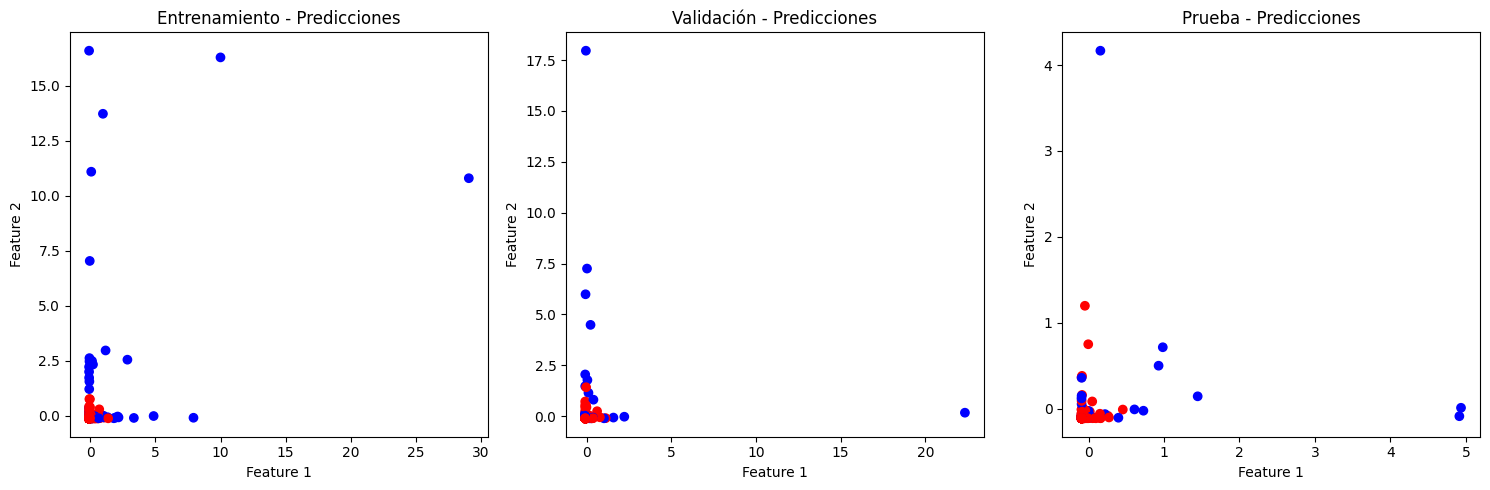

In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

## TODO hasta que punto son anómalos estos registros y que hacer con ellos si de verdad lo son (cambiar a mano, borrar, entrenar por separado datos anómalos y normales) 
# Nos interesa borrar registros ? tenemos un número no muy elevado de ellos 
model_name = 'Detección de Anomalías (Isolation Forest)'
print(model_name)

# Convertir los conjuntos de datos a numpy arrays si no lo son ya
X_train_prep = np.array(X_train_prep)
X_val_prep = np.array(X_val_prep)
X_test_prep = np.array(X_test_prep)

# Entrenar el modelo Isolation Forest
model_isolation_forest = IsolationForest(contamination=0.1, random_state=42)
model_isolation_forest.fit(X_train_prep)

# Predicción de anomalías en el conjunto de entrenamiento, validación y prueba
anomalies_train = model_isolation_forest.predict(X_train_prep)
anomalies_val = model_isolation_forest.predict(X_val_prep)
anomalies_test = model_isolation_forest.predict(X_test_prep)

# Convertir las predicciones a etiquetas binarias (0 para normal, 1 para anomalía)
anomalies_train_labels = np.where(anomalies_train == -1, 1, 0)
anomalies_val_labels = np.where(anomalies_val == -1, 1, 0)
anomalies_test_labels = np.where(anomalies_test == -1, 1, 0)

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, anomalies_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, anomalies_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, anomalies_test, "Test", model_name)

# Eliminar registros anómalos
X_train_prep_sin_anom = X_train_prep[anomalies_train_labels == 0]
X_val_prep_sin_anom = X_val_prep[anomalies_val_labels == 0]
X_test_prep_sin_anom = X_test_prep[anomalies_test_labels == 0]

# Label por color
def label_to_color(y_pred):
    return ['blue' if y == 1 else 'red' for y in y_pred]

# Mostrar los resultados
plt.figure(figsize=(15, 5))

# Conjunto de Entrenamiento
plt.subplot(1, 3, 1)
plt.title("Entrenamiento - Predicciones")
plt.scatter(X_train_prep[:, 0], X_train_prep[:, 1], color=label_to_color(anomalies_train_labels))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Conjunto de Validación
plt.subplot(1, 3, 2)
plt.title("Validación - Predicciones")
plt.scatter(X_val_prep[:, 0], X_val_prep[:, 1], color=label_to_color(anomalies_val_labels))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Conjunto de Prueba
plt.subplot(1, 3, 3)
plt.title("Prueba - Predicciones")
plt.scatter(X_test_prep[:, 0], X_test_prep[:, 1], color=label_to_color(anomalies_test_labels))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

## Reducción de dimensionalidad SVD

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

## TODO ver si interesa reducir componentes. De primeras para la detección del cancer diría que no ya que hemos reducido a 9 variables previamente.
model_name = 'Reducción de Dimensionalidad SVD'
print(model_name)

max_components = X_train_prep.shape[1]

# Crear y ajustar el modelo SVD
model_SVD = TruncatedSVD(n_components=max_components)
model_SVD.fit(X_train_prep)

# Calcular la varianza explicada acumulada para establecer el peso de cada variable 
explained_variance_ratio = model_SVD.explained_variance_ratio_
cumulative_explained_variance = np.sum(explained_variance_ratio)
print("Varianza explicada acumulada:", cumulative_explained_variance)

# Aplicar el modelo SVD a los datos de entrenamiento, validación y prueba
X_train_reduced = model_SVD.transform(X_train_prep)
X_val_reduced = model_SVD.transform(X_val_prep)
X_test_reduced = model_SVD.transform(X_test_prep)

# Usamos Kmeans para poder dar valores a los los datos labels_train, labels_val y labels_test
model_KM = KMeans(random_state=42)

# Obtención del número de clusters optimo, escoger entre elbow o silhouette
optimal_k = optimal_cluster_number(X_train_prep, X_val_prep, model_KM, method='silhouette')
print(optimal_k)
# Ajustar el modelo con el número óptimo de clusters
kmeans = KMeans(n_clusters = optimal_k)
labels_train = kmeans.fit_predict(X_train_reduced)
labels_val = kmeans.predict(X_val_reduced)
labels_test = kmeans.predict(X_test_reduced)

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_reduced, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_reduced, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_reduced, labels_test, "Test", model_name)


## Transformar tabla_results_NS_df a formato Excel

In [ ]:
tabla_results_NS_df.to_excel('model_results_NS.xlsx', index=False)

## Borrar informacion de las tablas

In [ ]:
# Borrar todos los registros
tabla_results_df = tabla_results_df.iloc[0:0]
tabla_results_NS_df = tabla_results_NS_df.iloc[0:0]

# Cruces entre modelos  no supervisados y supervisados

## Test 1 - K-means + Random Forest 

# Creación de datos sintéticos mediante CTGAN

In [41]:
!pip install imblearn ctgan lightgbm torch

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------- ----------- 41.0/57.6 kB 1.9 MB/s eta 0:00:01
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 3.6 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.4 MB 3.4 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.4 MB 3.4 MB/s eta 0:00:01
   -------- ------------------------------- 0.3/1.4 MB 1.7 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.4 MB 2.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.4 MB 2.5 MB/s eta 0:00:01
   ------------------------ --------------- 0.9/1.4 MB 2.8 MB/s eta 0:00:01
   -------------------------- ------------- 0.9/1.4 MB 2.8 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.4 MB 2.3 MB/s eta 0:00:01
   ------------


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE
from ctgan import CTGAN
import lightgbm as lgb
import xgboost as xgb
import torch
from CancerPredictionMLflow.src.CancerPrediction.entity.config_entity import ModelTrainerConfig
from CancerPredictionMLflow.src.CancerPrediction import logger

def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig, params: dict, seed: int = 42):
        self.config = config
        self.params = params
        self.seed = seed
        set_seed(self.seed)

    def train(self):
        # Cargar datos de entrenamiento y prueba
        train_data = pd.read_excel(self.config.train_data_path)
        test_data = pd.read_excel(self.config.test_data_path)

        # Combinar datos de entrenamiento y prueba
        df_combined = pd.concat([train_data, test_data], axis=0)

        # Seleccionar características importantes
        X_real = df_combined[self.config.important_features]
        y_real = df_combined[self.config.target_column]

        # Identificar clases minoritarias
        class_counts = y_real.value_counts()
        minority_classes = class_counts[class_counts < class_counts.median()].index

        # Separar datos de clases minoritarias
        X_minority = X_real[y_real.isin(minority_classes)]
        y_minority = y_real[y_real.isin(minority_classes)]

        # Entrenar el modelo CTGAN solo con las clases minoritarias
        ctgan_params = self.params['CTGAN']
        model = CTGAN(**ctgan_params)
        model.fit(X_minority)

        # Generar datos sintéticos para las clases minoritarias
        synthetic_data_minority = model.sample(len(X_minority))

        # Asignar etiquetas correctas a los datos sintéticos generados
        synthetic_data_minority[self.config.target_column] = np.random.choice(minority_classes, len(synthetic_data_minority))

        # Separar características y etiquetas de los datos sintéticos generados
        X_synthetic = synthetic_data_minority[self.config.important_features]
        y_synthetic = synthetic_data_minority[self.config.target_column]

        # Combinar datos reales y datos sintéticos generados
        X_combined = pd.concat([X_real, X_synthetic], axis=0)
        y_combined = pd.concat([y_real, y_synthetic], axis=0)

        # Aplicar SMOTE para sobremuestrear las clases minoritarias en el conjunto combinado
        smote = SMOTE(random_state=self.seed)
        X_resampled, y_resampled = smote.fit_resample(X_combined, y_combined)

        # Dividir en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=self.seed, stratify=y_resampled)

        # Definir los modelos individuales con regularización
        rf_clf = RandomForestClassifier(random_state=self.seed, **self.params['RandomForest'])
        gb_clf = GradientBoostingClassifier(random_state=self.seed, **self.params['GradientBoosting'])
        lgbm_clf = lgb.LGBMClassifier(random_state=self.seed, **self.params['LightGBM'])
        xgb_clf = xgb.XGBClassifier(random_state=self.seed, **self.params['XGBoost'])

        # Definir el Voting Classifier
        voting_clf = VotingClassifier(
            estimators=[
                ('rf', rf_clf),
                ('gb', gb_clf),
                ('lgbm', lgbm_clf),
                ('xgb', xgb_clf)
            ],
            voting='soft'  # 'soft' uses predicted probabilities
        )

        # Entrenar el Voting Classifier con todos los datos resampleados
        voting_clf.fit(X_train, y_train)

        # Guardar el modelo entrenado
        joblib.dump(voting_clf, os.path.join(self.config.root_dir, self.config.model_name))

        # Guardar las características importantes utilizadas para el entrenamiento
        important_features_path = os.path.join(self.config.root_dir, 'important_features.json')
        with open(important_features_path, 'w') as f:
            json.dump(self.config.important_features, f)

        # Evaluar el modelo
        y_pred = voting_clf.predict(X_test)
        print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
        print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

In [34]:
!pip install ctgan

  Using cached ctgan-0.10.1-py3-none-any.whl.metadata (11 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached rdt-1.12.1-py3-none-any.whl.metadata (10 kB)
  Using cached torch-2.3.1-cp312-cp312-win_amd64.whl.metadata (26 kB)
  Using cached Faker-26.0.0-py3-none-any.whl.metadata (15 kB)
  Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached sympy-1.12.1-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached tbb-2021.13.0-py3-none-win_amd64.whl.metadata (1.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached ctgan-0.10.1-py3-none-any.whl (24 kB)
Using cached rdt-1.12.1-py3-none-any.whl (63 kB)
Using cached torch-2.3.1-cp312-cp312

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import joblib
from ctgan import CTGAN
from sklearn.model_selection import ParameterGrid
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class CTGANTrainer:
    def __init__(self, param_grid, model_path, pac=1):
        self.param_grid = param_grid
        self.model_path = model_path
        self.pac = pac

    def evaluate_ctgan(self, params, X):
        # Ajustar los parámetros de CTGAN
        params['pac'] = self.pac
        model = CTGAN(**params)
        model.fit(X)

        # Generar una muestra sintética
        synthetic_data = model.sample(len(X))
        
        return synthetic_data

    def grid_search(self, X):
        # Realizar la búsqueda de hiperparámetros
        best_score = -np.inf
        best_params = None

        for params in ParameterGrid(self.param_grid):
            synthetic_data = self.evaluate_ctgan(params, X)
            score = self.calculate_score(X, synthetic_data)
            if score > best_score:
                best_score = score
                best_params = params

        return best_params

    def calculate_score(self, real_data, synthetic_data):
        # Aquí puedes implementar la métrica de evaluación que desees
        # En este caso, se puede comparar alguna métrica entre los datos reales y sintéticos
        return 0  # Ejemplo simplificado, implementa tu métrica adecuada aquí

    def train_and_save(self, df):
        # Convertir numpy array de vuelta a DataFrame si es necesario
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df, columns=self.feature_names)

        # Ajustar el preprocesador si es necesario
        # Asumiendo que ya tienes preprocesado tu dataframe

        # Separar características (X)
        X = df
        
        model = CTGAN(**param_grid)
        model.fit(X)

        # Guardar el modelo entrenado
        joblib.dump(model, self.model_path)

    def load_model(self):
        # Cargar el modelo entrenado
        return joblib.load(self.model_path)

    def generate_sample(self, model, num_samples=1):
        # Generar datos sintéticos
        return model.sample(num_samples)

# Ejemplo de uso:
# Definir el grid de hiperparámetros para CTGAN
param_grid = {
    'epochs': 200,
    'batch_size': 500,
    'discriminator_steps': 1,
    'verbose': [False]
}

# Ruta donde se guardará el modelo entrenado
model_path = 'Modelo CTGAN/ctgan_model.pkl'

# Crear instancia del entrenador CTGAN
trainer = CTGANTrainer(param_grid, model_path, pac=1)

# Suponiendo que 'df' es el dataframe completo proporcionado
# Asumiendo que ya tienes df preprocesado y df_reduced sin la variable objetivo
# target_column = 'Tumor type'  # Columna objetivo

# Entrenar y guardar el modelo con el df del segundo enfoque
trainer.train_and_save(df_reduced_segundo_enfoque)

# Cargar el modelo y generar un único registro sintético
model = trainer.load_model()

synthetic_sample = trainer.generate_sample(model, num_samples=1)

print(synthetic_sample)


Gen. (-2.77) | Discrim. (0.01): 100%|██████████| 200/200 [00:25<00:00,  7.76it/s] 


   Tumor type    OPN (pg/ml)  IL-6 (pg/ml)  IL-8 (pg/ml)  HGF (pg/ml)  \
0           0  269580.929884      6.949772     -5.056433    144.60657   

   Prolactin (pg/ml)  Omega score  GDF15 (ng/ml)  CYFRA 21-1 (pg/ml)  \
0        6555.814118      1.31604       0.609534          4779.84735   

   Myeloperoxidase (ng/ml)  sEGFR (pg/ml)  
0                 3.025341    1242.940246  


# Conclusiones